# Predcition of Hospital Admission Related to Combiination of Upper Respiratory Tract Infection, Cough, Cold with Cough, and Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection, cough, cough cold, and sore throat combinied together, called urti_combined.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process urti_combined data
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [6]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [10]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [19]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_antibacterial_brit_cat_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [20]:
#read datasets 
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_cough = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_cough_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [21]:
#convert data into combined_urti and concatenate them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_cough_converted = proc_infec_data_combined_urti(data_cough, 'cough')
data_cough_cold_converted = proc_infec_data_combined_urti(data_cough_cold, 'cough_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_cough_converted, data_cough_cold_converted, data_throat_converted]
data = pd.concat(frames)

In [22]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [23]:
#process 20 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [24]:
##add variable season
#convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] 
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

In [25]:
#add variable time period
data_urti_combined.loc[(data_urti_combined['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti_combined.loc[((data_urti_combined['date'] >= '2020-01') & (data_urti_combined['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti_combined.loc[(data_urti_combined['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [26]:
#scenario 1
#not hosped (nothing happened)
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0

In [27]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]

In [28]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [29]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30

#give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

In [30]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [31]:
#drop anybody with age less than 18 or 0!
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)] 
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

In [32]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking})

In [33]:
#drop rows with missing region
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
   data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_urti_combined.columns) and (data_urti_combined['smoking_status'].isnull().sum() > 0):
    data_urti_combined['smoking_status'] = data_urti_combined['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

In [34]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti_combined['bmi_cat'] = 5

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 30:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 25) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 30):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 18.5) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 25):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 18.5:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

In [35]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])
#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)

In [ ]:
##add a variable for category of antibiotic history 
#categorise antibiotic hisotry
data_urti_combined['antibacterial_brit_cat'] = pd.cut(data_urti_combined['antibacterial_brit'], right=False, bins=[0,1,2,5,10000], labels=['none0', 'low1', 'medium2_4', 'high5_more'])
data_urti_combined['antibacterial_brit_cat'].value_counts()

### 2-4- translate values of categorical variables

In [36]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [37]:
#categorise CCI
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)
#categorise antibiotic hisotry
data_urti_combined['antibacterial_brit_cat'] = pd.cut(data_urti_combined['antibacterial_brit'], right=False, bins=[0,1,2,5,10000], labels=['none0', 'low1', 'medium2_4', 'high5_more'])
data_urti_combined['antibacterial_brit_cat'].value_counts()

none0              363171
medium2_3          243226
high4_7             56214
low1                48277
very_high8_more         0
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

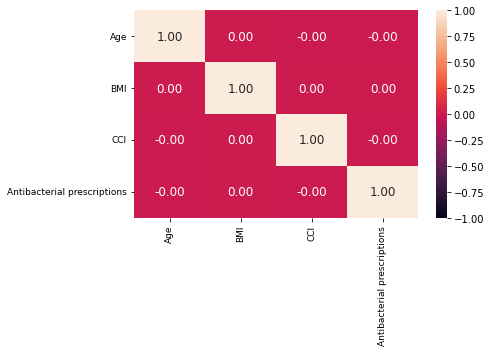

In [38]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [39]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'antibacterial_brit_cat', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date', 'period',
                                   'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                                    ]]

In [40]:
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined_incdt[['urti_combined_ab_date']] = data_urti_combined_incdt[['urti_combined_ab_date']].where(data_urti_combined_incdt[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_combined_prevl[['urti_combined_ab_date']] = data_urti_combined_prevl[['urti_combined_ab_date']].where(data_urti_combined_prevl[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_urti_combined_incdt_males = data_urti_combined_incdt[data_urti_combined_incdt['sex'] == 'male']
data_urti_combined_incdt_females = data_urti_combined_incdt[data_urti_combined_incdt['sex'] == 'female']
data_urti_combined_prevl_males = data_urti_combined_prevl[data_urti_combined_prevl['sex'] == 'male']
data_urti_combined_prevl_females = data_urti_combined_prevl[data_urti_combined_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_urti_combined_incdt_15_24 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '15_24']
data_urti_combined_incdt_25_34 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '25_34']
data_urti_combined_incdt_35_44 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '35_44']
data_urti_combined_incdt_45_54 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '45_54']
data_urti_combined_incdt_55_64 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '55_64']
data_urti_combined_incdt_65_74 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '65_74']
data_urti_combined_incdt_75_more = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '75_more']
data_urti_combined_prevl_15_24 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '15_24']
data_urti_combined_prevl_25_34 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '25_34']
data_urti_combined_prevl_35_44 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '35_44']
data_urti_combined_prevl_45_54 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '45_54']
data_urti_combined_prevl_55_64 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '55_64']
data_urti_combined_prevl_65_74 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '65_74']
data_urti_combined_prevl_75_more = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['date'] <= '2019-12']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['date'] >= '2020-03') & (data_urti_combined_incdt['date']<= '2021-03')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['date'] <= '2021-04']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['date'] <= '2019-12']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['date'] >= '2020-03') & (data_urti_combined_prevl['date']<= '2021-03')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['date'] <= '2021-04']

#incident and prevalent infection stratified by antibiotics history categories
data_urti_combined_incdt_none0 = data_urti_combined_incdt[data_urti_combined_incdt['antibacterial_brit_cat'] == 'none0']
data_urti_combined_incdt_low1 = data_urti_combined_incdt[data_urti_combined_incdt['antibacterial_brit_cat'] == 'low1']
data_urti_combined_incdt_medium2_4 = data_urti_combined_incdt[data_urti_combined_incdt['antibacterial_brit_cat'] == 'medium2_4']
data_urti_combined_incdt_high5_more = data_urti_combined_incdt[data_urti_combined_incdt['antibacterial_brit_cat'] == 'high5_more']
data_urti_combined_prevl_none0 = data_urti_combined_prevl[data_urti_combined_prevl['antibacterial_brit_cat'] == 'none0']
data_urti_combined_prevl_low1 = data_urti_combined_prevl[data_urti_combined_prevl['antibacterial_brit_cat'] == 'low1']
data_urti_combined_prevl_medium2_4 = data_urti_combined_prevl[data_urti_combined_prevl['antibacterial_brit_cat'] == 'medium2_4']
data_urti_combined_prevl_high5_more = data_urti_combined_prevl[data_urti_combined_prevl['antibacterial_brit_cat'] == 'high5_more']

# no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined[data_urti_combined['urti_combined_ab_date'].isnull()]
data_urti_combined_no_abs_incdt = data_urti_combined_no_abs_incdt[data_urti_combined_no_abs_incdt['incdt_urti_combined_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined[data_urti_combined['urti_combined_ab_date'].notnull()]
data_urti_combined_abs_incdt = data_urti_combined_abs_incdt[data_urti_combined_abs_incdt['incdt_urti_combined_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined[data_urti_combined['urti_combined_ab_date'].isnull()]
data_urti_combined_no_abs_prevl = data_urti_combined_no_abs_prevl[data_urti_combined_no_abs_prevl['incdt_urti_combined_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined[data_urti_combined['urti_combined_ab_date'].notnull()]
data_urti_combined_abs_prevl = data_urti_combined_abs_prevl[data_urti_combined_abs_prevl['incdt_urti_combined_date'] == 1]

In [41]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_urti_combined' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident urti_combined with no antibiotics

<lifelines.CoxPHFitter: fitted with 431984 total observations, 429212 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 431984
number of events observed = 2772
   partial log-likelihood = -35944.48
         time fit was run = 2023-06-21 09:57:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.06            -0.07             0.16                 0.94                 1.17
CCI_cat[T.medium]                0.15       1.16       0.06             0.03             0.27                 1.03                 1.31
CCI_cat[T.high]                  0.03       1.03       0.08            -0.12             0.18                 0.88                 1.19
CCI_cat[T.very_high]             0.04       1.04       0.07            -0.09             0.17                 0.91                 1.18
age_cat[T.25_34]                 0.01       1.01       0.07            -0.13             0.15                 0.88                 1.16
age_cat[T.35_44]                 0.02       1.03       0.07            -0.11             0.16                 0.89                 1.18
age_cat[T.45_54]                 0.04       1.04       0.07            -0.10             0.18                 0.90                 1.19
age_cat[T.55_64]                 0.02       1.02       0.07            -0.12             0.16                 0.88                 1.17
age_cat[T.65_74]                -0.02       0.98       0.07            -0.16             0.12                 0.85                 1.13
age_cat[T.75_more]               0.03       1.03       0.07            -0.11             0.17                 0.90                 1.19
antibacterial_brit               0.01       1.01       0.01            -0.02             0.03                 0.98                 1.03
bmi_cat[T.obese]                 0.02       1.02       0.07            -0.13             0.16                 0.88                 1.17
bmi_cat[T.overweight]           -0.10       0.91       0.09            -0.27             0.08                 0.76                 1.08
bmi_cat[T.underweight]           0.07       1.07       0.12            -0.17             0.31                 0.84                 1.36
bmi_cat[T.unknown]               0.03       1.03       0.08            -0.12             0.18                 0.89                 1.19
ethnicity[T.unknown]            -0.10       0.91       0.06            -0.22             0.03                 0.80                 1.03
ethnicity[T.white]               0.02       1.02       0.05            -0.09             0.12                 0.91                 1.13
flu_vaccine[T.yes]              -0.05       0.95       0.06            -0.18             0.07                 0.84                 1.08
imd[T.medium]                    0.02       1.02       0.06            -0.10             0.14                 0.91                 1.15
imd[T.unaffluent]               -0.03       0.97       0.06            -0.15             0.09                 0.86                 1.09
imd[T.unknown]                   0.09       1.09       0.09            -0.10             0.27                 0.91                 1.31
imd[T.very_affluent]            -0.03       0.97       0.06            -0.15             0.09                 0.86                 1.09
imd[T.very_unaffluent]          -0.04       0.96       0.06            -0.16             0.08                 0.85                 1.08
region[T.east_midlands]          0.01       1.01       0.08            -0.15             0.18                 0.86                 1.19
region[T.london]                -0.05       0

12785


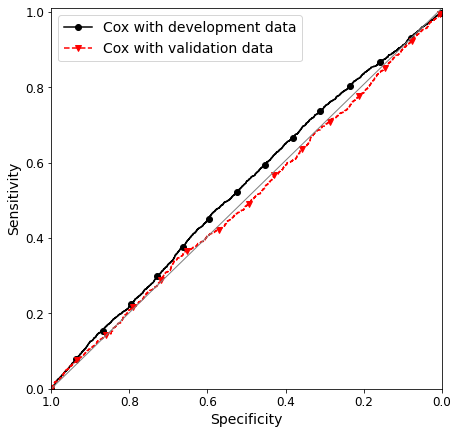

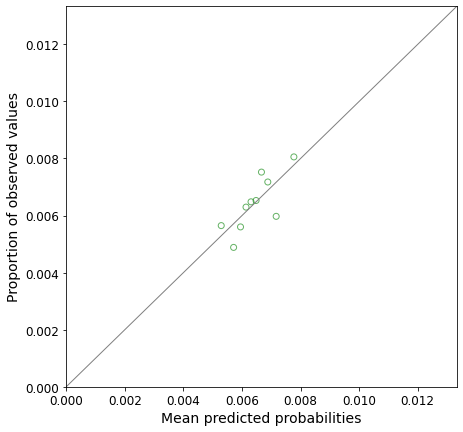

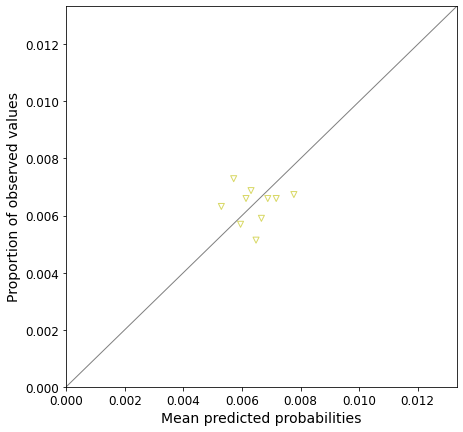

In [42]:
#data prep
data, data_urti_combined_no_abs_incdt_enc = cox_data_prep(data_urti_combined_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)

try:
    #build cox model 
    cph_urti_combined_no_abs_incdt, data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test = cox_model_build('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_no_abs_incdt, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_no_abs_incdt.csv', data_urti_combined_no_abs_incdt_enc, data_urti_combined_no_abs_incdt, 'sum_betas_cph_urti_combined_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_no_abs_incdt, 'event_urti_combined_admitted', data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_no_abs_incdt, data_urti_combined_no_abs_incdt_train, 'event_urti_combined_admitted', data_urti_combined_no_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_no_abs_incdt_train.jpg', 'calibration_cph_urti_combined_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_no_abs_incdt, 'urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident urti_combined with antibiotics

<lifelines.CoxPHFitter: fitted with 47961 total observations, 47692 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 47961
number of events observed = 269
   partial log-likelihood = -2879.11
         time fit was run = 2023-06-21 09:58:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.18            -0.19             0.53                 0.82                 1.69
CCI_cat[T.medium]                0.03       1.03       0.21            -0.37             0.44                 0.69                 1.55
CCI_cat[T.high]                  0.11       1.12       0.24            -0.36             0.58                 0.70                 1.79
CCI_cat[T.very_high]            -0.00       1.00       0.22            -0.43             0.42                 0.65                 1.53
age_cat[T.25_34]                -0.01       0.99       0.22            -0.43             0.42                 0.65                 1.52
age_cat[T.35_44]                -0.16       0.85       0.23            -0.60             0.29                 0.55                 1.33
age_cat[T.45_54]                -0.17       0.85       0.23            -0.62             0.28                 0.54                 1.32
age_cat[T.55_64]                -0.18       0.84       0.23            -0.63             0.27                 0.53                 1.31
age_cat[T.65_74]                -0.06       0.94       0.22            -0.50             0.37                 0.61                 1.45
age_cat[T.75_more]              -0.04       0.96       0.22            -0.47             0.40                 0.62                 1.49
antibacterial_brit              -0.01       0.99       0.04            -0.09             0.08                 0.91                 1.08
bmi_cat[T.obese]                 0.08       1.08       0.23            -0.38             0.54                 0.68                 1.71
bmi_cat[T.overweight]            0.14       1.15       0.28            -0.40             0.69                 0.67                 2.00
bmi_cat[T.underweight]           0.18       1.20       0.38            -0.57             0.93                 0.56                 2.54
bmi_cat[T.unknown]              -0.06       0.94       0.25            -0.56             0.44                 0.57                 1.55
ethnicity[T.unknown]             0.31       1.36       0.21            -0.11             0.72                 0.90                 2.06
ethnicity[T.white]               0.24       1.28       0.19            -0.13             0.62                 0.87                 1.86
flu_vaccine[T.yes]              -0.06       0.94       0.21            -0.47             0.34                 0.63                 1.41
imd[T.medium]                    0.31       1.37       0.19            -0.06             0.69                 0.94                 1.99
imd[T.unaffluent]                0.27       1.31       0.19            -0.10             0.65                 0.90                 1.92
imd[T.unknown]                  -0.46       0.63       0.38            -1.21             0.29                 0.30                 1.34
imd[T.very_affluent]            -0.04       0.96       0.21            -0.45             0.36                 0.64                 1.44
imd[T.very_unaffluent]          -0.19       0.82       0.21            -0.61             0.23                 0.54                 1.25
region[T.east_midlands]         -0.13       0.88       0.25            -0.63             0.36                 0.53                 1.44
region[T.london]                -0.35       0.71  

12796


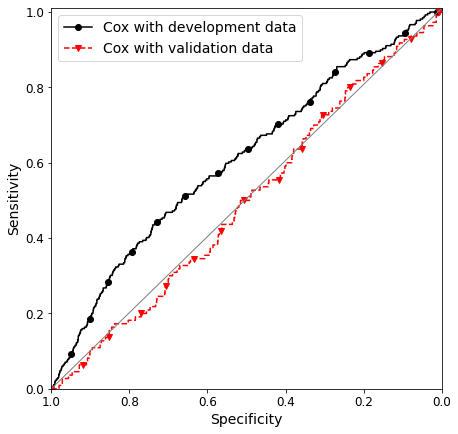

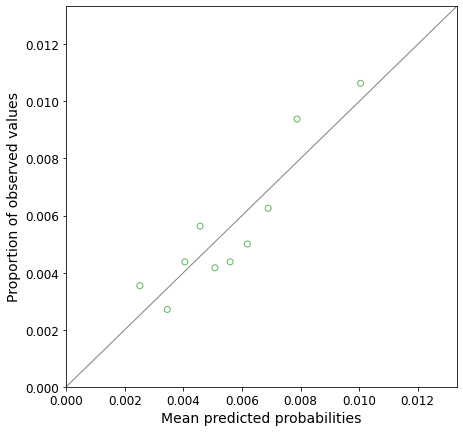

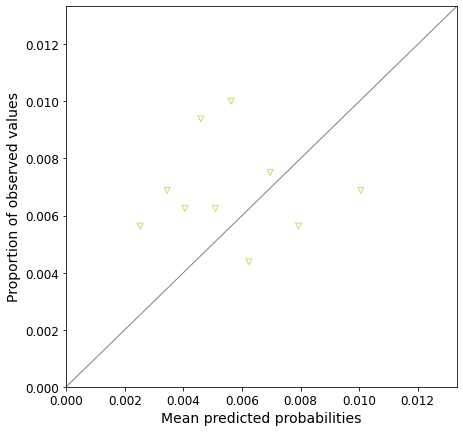

In [43]:
#data prep
data, data_urti_combined_abs_incdt_enc = cox_data_prep(data_urti_combined_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)

try:
    #build cox model 
    cph_urti_combined_abs_incdt, data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test = cox_model_build('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_abs_incdt, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_abs_incdt.csv', data_urti_combined_abs_incdt_enc, data_urti_combined_abs_incdt, 'sum_betas_cph_urti_combined_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_abs_incdt, 'event_urti_combined_admitted', data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_abs_incdt, data_urti_combined_abs_incdt_train, 'event_urti_combined_admitted', data_urti_combined_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_abs_incdt_train.jpg', 'calibration_cph_urti_combined_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_abs_incdt, 'urti_combined', 'abs_incdt', data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent urti_combined with no antibiotics

<lifelines.CoxPHFitter: fitted with 47748 total observations, 47463 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 47748
number of events observed = 285
   partial log-likelihood = -3045.42
         time fit was run = 2023-06-21 09:58:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.31       1.37       0.21            -0.09             0.72                 0.92                 2.05
CCI_cat[T.medium]                0.54       1.72       0.21             0.12             0.96                 1.13                 2.62
CCI_cat[T.high]                  0.33       1.39       0.26            -0.18             0.84                 0.84                 2.31
CCI_cat[T.very_high]             0.74       2.09       0.22             0.31             1.16                 1.37                 3.18
age_cat[T.25_34]                -0.55       0.57       0.23            -1.00            -0.10                 0.37                 0.90
age_cat[T.35_44]                -0.32       0.72       0.21            -0.74             0.09                 0.48                 1.10
age_cat[T.45_54]                -0.04       0.96       0.20            -0.43             0.35                 0.65                 1.42
age_cat[T.55_64]                -0.28       0.75       0.21            -0.69             0.13                 0.50                 1.14
age_cat[T.65_74]                -0.29       0.75       0.21            -0.71             0.12                 0.49                 1.13
age_cat[T.75_more]              -0.47       0.63       0.22            -0.90            -0.03                 0.41                 0.97
antibacterial_brit              -0.01       0.99       0.04            -0.09             0.07                 0.91                 1.07
bmi_cat[T.obese]                -0.11       0.90       0.22            -0.53             0.32                 0.59                 1.38
bmi_cat[T.overweight]            0.09       1.10       0.26            -0.41             0.60                 0.66                 1.82
bmi_cat[T.underweight]          -0.09       0.92       0.39            -0.85             0.68                 0.43                 1.96
bmi_cat[T.unknown]              -0.18       0.84       0.23            -0.64             0.28                 0.53                 1.32
ethnicity[T.unknown]             0.06       1.06       0.20            -0.33             0.44                 0.72                 1.55
ethnicity[T.white]               0.04       1.04       0.17            -0.30             0.38                 0.74                 1.46
flu_vaccine[T.yes]              -0.12       0.89       0.21            -0.52             0.28                 0.59                 1.33
imd[T.medium]                   -0.36       0.70       0.20            -0.75             0.03                 0.47                 1.03
imd[T.unaffluent]               -0.12       0.88       0.19            -0.49             0.24                 0.61                 1.28
imd[T.unknown]                   0.03       1.04       0.28            -0.52             0.59                 0.60                 1.80
imd[T.very_affluent]            -0.11       0.90       0.19            -0.47             0.25                 0.62                 1.29
imd[T.very_unaffluent]          -0.11       0.90       0.19            -0.47             0.26                 0.62                 1.30
region[T.east_midlands]          0.03       1.03       0.30            -0.56             0.61                 0.57                 1.85
region[T.london]                 0.23       1.26  

12795


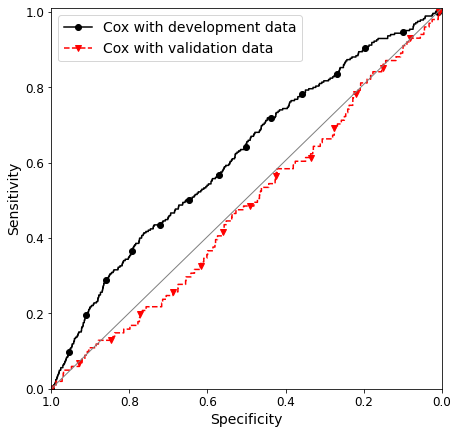

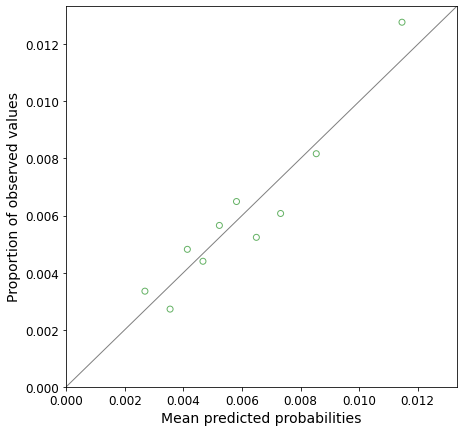

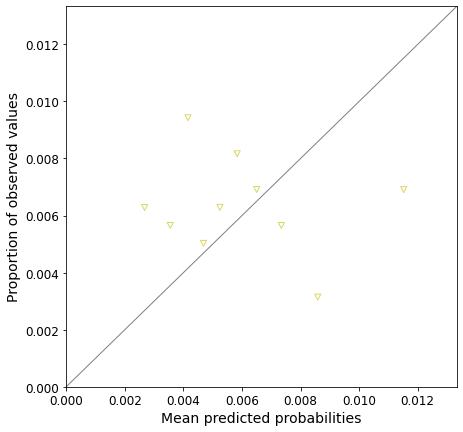

In [44]:
#data prep
data, data_urti_combined_no_abs_prevl_enc = cox_data_prep(data_urti_combined_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)

try:
    #build cox model 
    cph_urti_combined_no_abs_prevl, data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test = cox_model_build('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_no_abs_prevl, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_no_abs_prevl.csv', data_urti_combined_no_abs_prevl_enc, data_urti_combined_no_abs_prevl, 'sum_betas_cph_urti_combined_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_no_abs_prevl, 'event_urti_combined_admitted', data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_no_abs_prevl, data_urti_combined_no_abs_prevl_train, 'event_urti_combined_admitted', data_urti_combined_no_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_no_abs_prevl_train.jpg', 'calibration_cph_urti_combined_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_no_abs_prevl, 'urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent urti_combined with antibiotics

<lifelines.CoxPHFitter: fitted with 5472 total observations, 5434 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 5472
number of events observed = 38
   partial log-likelihood = -303.80
         time fit was run = 2023-06-21 09:58:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.40       0.67       0.46            -1.30             0.51                 0.27                 1.66
CCI_cat[T.medium]                0.02       1.02       0.47            -0.90             0.94                 0.41                 2.56
CCI_cat[T.high]                 -0.99       0.37       0.80            -2.55             0.57                 0.08                 1.76
CCI_cat[T.very_high]            -0.53       0.59       0.57            -1.65             0.60                 0.19                 1.82
age_cat[T.25_34]                -1.10       0.33       0.82            -2.71             0.51                 0.07                 1.67
age_cat[T.35_44]                -0.65       0.52       0.71            -2.05             0.74                 0.13                 2.10
age_cat[T.45_54]                -1.08       0.34       0.82            -2.69             0.52                 0.07                 1.68
age_cat[T.55_64]                -0.03       0.97       0.58            -1.16             1.11                 0.31                 3.04
age_cat[T.65_74]                 0.13       1.14       0.56            -0.97             1.23                 0.38                 3.42
age_cat[T.75_more]               0.67       1.96       0.50            -0.31             1.66                 0.73                 5.26
antibacterial_brit              -0.08       0.93       0.12            -0.31             0.16                 0.74                 1.17
bmi_cat[T.obese]                 0.97       2.63       1.03            -1.05             2.99                 0.35                19.79
bmi_cat[T.overweight]            1.71       5.55       1.06            -0.37             3.80                 0.69                44.56
bmi_cat[T.underweight]           0.91       2.48       1.42            -1.88             3.69                 0.15                40.17
bmi_cat[T.unknown]               1.15       3.16       1.05            -0.91             3.21                 0.40                24.86
ethnicity[T.unknown]             0.45       1.57       0.59            -0.70             1.61                 0.50                 4.98
ethnicity[T.white]               0.42       1.53       0.54            -0.64             1.49                 0.53                 4.44
flu_vaccine[T.yes]              -0.60       0.55       0.73            -2.03             0.83                 0.13                 2.28
imd[T.medium]                    0.46       1.59       0.46            -0.44             1.36                 0.64                 3.90
imd[T.unaffluent]                0.13       1.14       0.49            -0.83             1.09                 0.44                 2.97
imd[T.unknown]                  -0.07       0.93       0.79            -1.63             1.48                 0.20                 4.41
imd[T.very_affluent]            -0.62       0.54       0.62            -1.83             0.59                 0.16                 1.81
imd[T.very_unaffluent]          -1.05       0.35       0.68            -2.38             0.28                 0.09                 1.33
region[T.east_midlands]          1.23       3.44       1.12            -0.96             3.43                 0.38                30.98
region[T.london]                 1.61       5.01       

12785


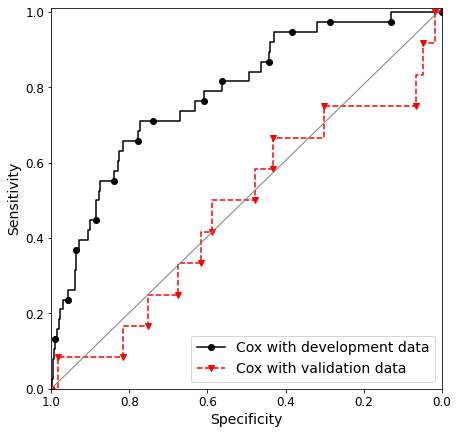

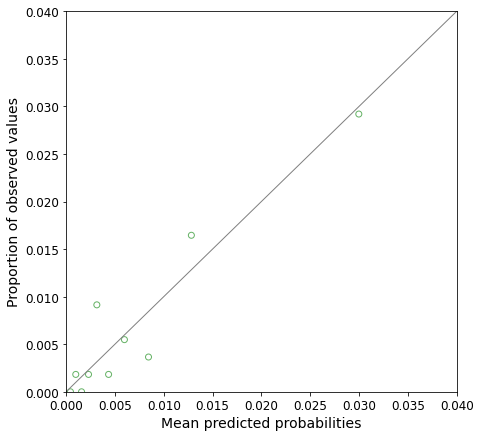

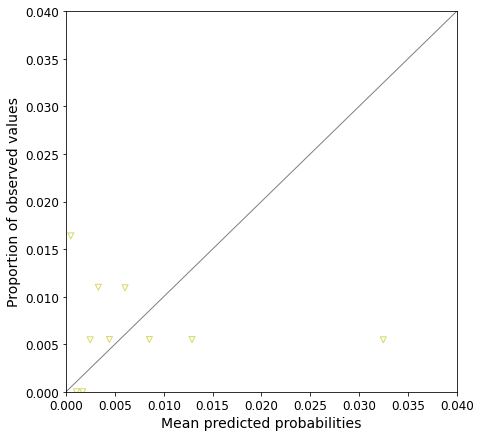

In [45]:
#data prep
data, data_urti_combined_abs_prevl_enc = cox_data_prep(data_urti_combined_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)

try:
    #build cox model 
    cph_urti_combined_abs_prevl, data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test = cox_model_build('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_abs_prevl, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_abs_prevl.csv', data_urti_combined_abs_prevl_enc, data_urti_combined_abs_prevl, 'sum_betas_cph_urti_combined_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_abs_prevl, 'event_urti_combined_admitted', data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_abs_prevl, data_urti_combined_abs_prevl_train, 'event_urti_combined_admitted', data_urti_combined_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_abs_prevl_train.jpg', 'calibration_cph_urti_combined_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_abs_prevl, 'urti_combined', 'abs_prevl', data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident urti_combined

In [46]:
#data prep
data, data_urti_combined_incdt_enc = cox_data_prep(data_urti_combined_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary tables from preped data
make_summary_table('urti_combined', 'incdt', data_urti_combined_incdt_enc)
make_summary_table_hosped('urti_combined', 'incdt', data_urti_combined_incdt)

try:
    cph_urti_combined_incdt, data_urti_combined_incdt_train, data_urti_combined_incdt_test = cox_model_abs_build('urti_combined', 'incdt', data_urti_combined_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt, 'urti_combined', 'incdt', data_urti_combined_incdt_train, data_urti_combined_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 479946 total observations, 476934 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 479946
number of events observed = 3012
   partial log-likelihood = -39371.55
         time fit was run = 2023-06-21 09:58:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.06            -0.08             0.14                 0.92                 1.14
CCI_cat[T.medium]                0.09       1.09       0.06            -0.03             0.20                 0.97                 1.23
CCI_cat[T.high]                  0.03       1.03       0.07            -0.11             0.18                 0.90                 1.19
CCI_cat[T.very_high]             0.08       1.09       0.06            -0.04             0.21                 0.96                 1.23
age_cat[T.25_34]                 0.02       1.02       0.07            -0.12             0.15                 0.89                 1.16
age_cat[T.35_44]                -0.01       0.99       0.07            -0.14             0.13                 0.87                 1.13
age_cat[T.45_54]                -0.01       0.99       0.07            -0.15             0.12                 0.86                 1.13
age_cat[T.55_64]                 0.02       1.02       0.07            -0.11             0.15                 0.89                 1.17
age_cat[T.65_74]                -0.02       0.98       0.07            -0.16             0.11                 0.85                 1.12
age_cat[T.75_more]               0.06       1.07       0.07            -0.07             0.20                 0.93                 1.22
antibacterial_brit              -0.01       0.99       0.01            -0.04             0.01                 0.97                 1.02
bmi_cat[T.obese]                 0.02       1.02       0.07            -0.11             0.16                 0.89                 1.17
bmi_cat[T.overweight]           -0.07       0.93       0.09            -0.24             0.09                 0.79                 1.10
bmi_cat[T.underweight]          -0.00       1.00       0.12            -0.24             0.23                 0.79                 1.26
bmi_cat[T.unknown]              -0.02       0.98       0.07            -0.16             0.13                 0.85                 1.14
ethnicity[T.unknown]            -0.12       0.89       0.06            -0.24            -0.00                 0.79                 1.00
ethnicity[T.white]              -0.00       1.00       0.05            -0.10             0.10                 0.90                 1.10
flu_vaccine[T.yes]              -0.01       0.99       0.06            -0.13             0.11                 0.88                 1.12
imd[T.medium]                    0.04       1.04       0.06            -0.07             0.15                 0.93                 1.17
imd[T.unaffluent]               -0.07       0.93       0.06            -0.19             0.05                 0.83                 1.05
imd[T.unknown]                  -0.02       0.98       0.09            -0.20             0.16                 0.82                 1.17
imd[T.very_affluent]            -0.01       0.99       0.06            -0.13             0.10                 0.88                 1.11
imd[T.very_unaffluent]          -0.11       0.90       0.06            -0.23             0.01                 0.80                 1.01
region[T.east_midlands]         -0.18       0.83       0.08            -0.34            -0.02                 0.71                 0.98
region[T.london]                -0.13       0

13085


### 5-6- hospital admission related to prevalent urti_combined

In [47]:
#data prep
data, data_urti_combined_prevl_enc = cox_data_prep(data_urti_combined_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary tables from preped data
make_summary_table('urti_combined', 'prevl', data_urti_combined_prevl_enc)
make_summary_table_hosped('urti_combined', 'prevl', data_urti_combined_prevl)

try:
    cph_urti_combined_prevl, data_urti_combined_prevl_train, data_urti_combined_prevl_test = cox_model_abs_build('urti_combined', 'prevl', data_urti_combined_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl, 'urti_combined', 'prevl', data_urti_combined_prevl_train, data_urti_combined_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 53220 total observations, 52899 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 53220
number of events observed = 321
   partial log-likelihood = -3470.88
         time fit was run = 2023-06-21 09:58:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.18            -0.21             0.49                 0.81                 1.63
CCI_cat[T.medium]                0.38       1.46       0.19             0.01             0.74                 1.01                 2.10
CCI_cat[T.high]                  0.04       1.04       0.24            -0.43             0.51                 0.65                 1.66
CCI_cat[T.very_high]             0.37       1.45       0.20            -0.02             0.75                 0.98                 2.13
age_cat[T.25_34]                -0.25       0.78       0.21            -0.65             0.16                 0.52                 1.17
age_cat[T.35_44]                -0.24       0.79       0.21            -0.64             0.17                 0.53                 1.18
age_cat[T.45_54]                -0.08       0.92       0.20            -0.47             0.31                 0.62                 1.36
age_cat[T.55_64]                -0.19       0.83       0.20            -0.58             0.21                 0.56                 1.24
age_cat[T.65_74]                -0.07       0.94       0.20            -0.45             0.32                 0.64                 1.38
age_cat[T.75_more]              -0.36       0.70       0.21            -0.78             0.05                 0.46                 1.05
antibacterial_brit               0.03       1.03       0.04            -0.05             0.10                 0.95                 1.11
bmi_cat[T.obese]                -0.22       0.80       0.20            -0.61             0.16                 0.54                 1.17
bmi_cat[T.overweight]            0.05       1.05       0.23            -0.41             0.51                 0.67                 1.66
bmi_cat[T.underweight]          -0.20       0.82       0.36            -0.91             0.51                 0.40                 1.67
bmi_cat[T.unknown]              -0.32       0.72       0.21            -0.75             0.10                 0.47                 1.10
ethnicity[T.unknown]             0.04       1.05       0.17            -0.30             0.39                 0.74                 1.47
ethnicity[T.white]              -0.13       0.88       0.16            -0.44             0.18                 0.64                 1.20
flu_vaccine[T.yes]              -0.21       0.81       0.20            -0.60             0.18                 0.55                 1.20
imd[T.medium]                   -0.30       0.74       0.19            -0.66             0.06                 0.51                 1.06
imd[T.unaffluent]                0.02       1.02       0.17            -0.32             0.35                 0.73                 1.42
imd[T.unknown]                  -0.02       0.98       0.27            -0.55             0.51                 0.58                 1.67
imd[T.very_affluent]            -0.22       0.80       0.18            -0.57             0.13                 0.56                 1.14
imd[T.very_unaffluent]          -0.13       0.87       0.18            -0.48             0.21                 0.62                 1.24
region[T.east_midlands]          0.29       1.33       0.29            -0.28             0.85                 0.76                 2.33
region[T.london]                 0.53       1.70  

13056


### 5-7- hospital admission related to incident urti_combined with prescribed antibiotics categories

In [48]:
#data prep
data, data_urti_combined_incdt_abs_enc = cox_data_prep(data_urti_combined_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_abs, data_urti_combined_incdt_abs_train, data_urti_combined_incdt_abs_test = cox_model_ab_type_build('urti_combined', 'incdt_ab_type', data_urti_combined_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_abs, 'urti_combined', 'incdt_abs', data_urti_combined_incdt_abs_train, data_urti_combined_incdt_abs_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 479946 total observations, 476934 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 479946
number of events observed = 3012
   partial log-likelihood = -39370.50
         time fit was run = 2023-06-21 09:59:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.06            -0.08             0.14                 0.92                 1.14
CCI_cat[T.medium]                0.09       1.09       0.06            -0.03             0.20                 0.97                 1.23
CCI_cat[T.high]                  0.03       1.03       0.07            -0.11             0.18                 0.90                 1.19
CCI_cat[T.very_high]             0.08       1.09       0.06            -0.04             0.21                 0.96                 1.23
ab_type_cat[T.Doxycycline]       0.64       1.89       0.43            -0.20             1.48                 0.82                 4.37
ab_type_cat[T.no]                0.25       1.28       0.27            -0.28             0.77                 0.76                 2.17
ab_type_cat[T.other]             0.22       1.24       0.27            -0.32             0.75                 0.73                 2.12
age_cat[T.25_34]                 0.02       1.02       0.07            -0.12             0.15                 0.89                 1.16
age_cat[T.35_44]                -0.01       0.99       0.07            -0.14             0.13                 0.87                 1.13
age_cat[T.45_54]                -0.01       0.99       0.07            -0.15             0.12                 0.86                 1.13
age_cat[T.55_64]                 0.02       1.02       0.07            -0.11             0.15                 0.89                 1.17
age_cat[T.65_74]                -0.02       0.98       0.07            -0.16             0.11                 0.85                 1.12
age_cat[T.75_more]               0.06       1.07       0.07            -0.07             0.20                 0.93                 1.22
antibacterial_brit              -0.01       0.99       0.01            -0.04             0.01                 0.97                 1.02
bmi_cat[T.obese]                 0.02       1.02       0.07            -0.11             0.16                 0.89                 1.17
bmi_cat[T.overweight]           -0.07       0.93       0.09            -0.24             0.09                 0.79                 1.10
bmi_cat[T.underweight]          -0.00       1.00       0.12            -0.24             0.23                 0.79                 1.26
bmi_cat[T.unknown]              -0.02       0.98       0.07            -0.16             0.13                 0.85                 1.14
ethnicity[T.unknown]            -0.12       0.89       0.06            -0.24            -0.00                 0.79                 1.00
ethnicity[T.white]              -0.00       1.00       0.05            -0.10             0.10                 0.90                 1.10
flu_vaccine[T.yes]              -0.01       0.99       0.06            -0.13             0.11                 0.88                 1.12
imd[T.medium]                    0.04       1.04       0.06            -0.07             0.15                 0.93                 1.17
imd[T.unaffluent]               -0.07       0.93       0.06            -0.19             0.05                 0.83                 1.05
imd[T.unknown]                  -0.02       0.98       0.09            -0.20             0.16                 0.82                 1.17
imd[T.very_affluent]            -0.01       0

13637


### 5-8- hospital admission related to prevalent urti_combined with prescribed antibiotics categories

In [49]:
#data prep
data, data_urti_combined_prevl_abs_enc = cox_data_prep(data_urti_combined_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_abs, data_urti_combined_prevl_abs_train, data_urti_combined_prevl_abs_test = cox_model_ab_type_build('urti_combined', 'prevl_ab_type', data_urti_combined_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_abs, 'urti_combined', 'prevl_abs', data_urti_combined_prevl_abs_train, data_urti_combined_prevl_abs_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 53220 total observations, 52899 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 53220
number of events observed = 321
   partial log-likelihood = -3469.97
         time fit was run = 2023-06-21 09:59:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.18            -0.21             0.49                 0.81                 1.64
CCI_cat[T.medium]                0.38       1.46       0.19             0.01             0.74                 1.01                 2.11
CCI_cat[T.high]                  0.04       1.04       0.24            -0.43             0.51                 0.65                 1.67
CCI_cat[T.very_high]             0.37       1.45       0.20            -0.01             0.76                 0.99                 2.13
ab_type_cat[T.Doxycycline]     -13.28       0.00     757.41         -1497.78          1471.22                 0.00                  inf
ab_type_cat[T.no]               -0.44       0.64       0.58            -1.58             0.69                 0.21                 2.00
ab_type_cat[T.other]            -0.46       0.63       0.61            -1.64             0.73                 0.19                 2.08
age_cat[T.25_34]                -0.25       0.78       0.21            -0.65             0.16                 0.52                 1.17
age_cat[T.35_44]                -0.24       0.79       0.21            -0.64             0.17                 0.53                 1.18
age_cat[T.45_54]                -0.08       0.92       0.20            -0.47             0.31                 0.63                 1.36
age_cat[T.55_64]                -0.19       0.83       0.20            -0.58             0.21                 0.56                 1.24
age_cat[T.65_74]                -0.07       0.94       0.20            -0.45             0.32                 0.64                 1.38
age_cat[T.75_more]              -0.36       0.70       0.21            -0.78             0.05                 0.46                 1.05
antibacterial_brit               0.03       1.03       0.04            -0.05             0.10                 0.95                 1.11
bmi_cat[T.obese]                -0.22       0.80       0.20            -0.61             0.16                 0.54                 1.17
bmi_cat[T.overweight]            0.05       1.05       0.23            -0.41             0.50                 0.67                 1.66
bmi_cat[T.underweight]          -0.20       0.82       0.36            -0.91             0.51                 0.40                 1.67
bmi_cat[T.unknown]              -0.33       0.72       0.21            -0.75             0.10                 0.47                 1.10
ethnicity[T.unknown]             0.05       1.05       0.17            -0.30             0.39                 0.74                 1.47
ethnicity[T.white]              -0.13       0.88       0.16            -0.44             0.18                 0.64                 1.20
flu_vaccine[T.yes]              -0.21       0.81       0.20            -0.60             0.18                 0.55                 1.20
imd[T.medium]                   -0.30       0.74       0.19            -0.66             0.06                 0.51                 1.06
imd[T.unaffluent]                0.02       1.02       0.17            -0.32             0.35                 0.73                 1.42
imd[T.unknown]                  -0.02       0.98       0.27            -0.55             0.51                 0.57                 1.67
imd[T.very_affluent]            -0.22       0.80  

13624


### 5-9- stratified by sex
#### 5-9-1- incident males

In [50]:
#data prep
data, data_urti_combined_incdt_males_enc = cox_data_prep(data_urti_combined_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_males, data_urti_combined_incdt_males_train, data_urti_combined_incdt_males_test = cox_model_strat_sex_build('urti_combined', 'incdt_males', data_urti_combined_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_males, 'urti_combined', 'incdt_males', data_urti_combined_incdt_males_train, data_urti_combined_incdt_males_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 235008 total observations, 233479 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 235008
number of events observed = 1529
   partial log-likelihood = -18889.75
         time fit was run = 2023-06-21 09:59:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.08            -0.20             0.10                 0.82                 1.10
CCI_cat[T.medium]                0.06       1.07       0.08            -0.10             0.22                 0.91                 1.25
CCI_cat[T.high]                 -0.07       0.93       0.10            -0.27             0.13                 0.76                 1.13
CCI_cat[T.very_high]            -0.05       0.95       0.09            -0.23             0.12                 0.80                 1.13
age_cat[T.25_34]                 0.07       1.07       0.09            -0.11             0.26                 0.89                 1.29
age_cat[T.35_44]                 0.11       1.12       0.09            -0.07             0.29                 0.93                 1.34
age_cat[T.45_54]                -0.11       0.90       0.10            -0.30             0.09                 0.74                 1.09
age_cat[T.55_64]                 0.06       1.07       0.09            -0.12             0.25                 0.89                 1.28
age_cat[T.65_74]                -0.03       0.97       0.10            -0.22             0.16                 0.80                 1.17
age_cat[T.75_more]              -0.07       0.93       0.10            -0.26             0.12                 0.77                 1.13
antibacterial_brit               0.01       1.01       0.02            -0.03             0.04                 0.97                 1.05
bmi_cat[T.obese]                 0.05       1.05       0.10            -0.14             0.24                 0.87                 1.27
bmi_cat[T.overweight]           -0.03       0.97       0.12            -0.27             0.21                 0.76                 1.23
bmi_cat[T.underweight]           0.18       1.20       0.16            -0.13             0.50                 0.88                 1.65
bmi_cat[T.unknown]               0.03       1.03       0.10            -0.18             0.23                 0.84                 1.26
ethnicity[T.unknown]            -0.06       0.94       0.09            -0.23             0.11                 0.80                 1.11
ethnicity[T.white]               0.06       1.06       0.07            -0.08             0.21                 0.92                 1.23
flu_vaccine[T.yes]              -0.04       0.96       0.09            -0.21             0.13                 0.81                 1.13
imd[T.medium]                   -0.06       0.94       0.08            -0.22             0.10                 0.80                 1.11
imd[T.unaffluent]               -0.07       0.93       0.08            -0.24             0.09                 0.79                 1.09
imd[T.unknown]                   0.03       1.03       0.13            -0.22             0.27                 0.80                 1.32
imd[T.very_affluent]             0.01       1.01       0.08            -0.15             0.17                 0.86                 1.19
imd[T.very_unaffluent]          -0.00       1.00       0.08            -0.16             0.16                 0.85                 1.17
region[T.east_midlands]         -0.01       0.99       0.12            -0.24             0.21                 0.79                 1.24
region[T.london]                 0.03       1

12810


#### 5-9-2- incident females

In [51]:
#data prep
data, data_urti_combined_incdt_females_enc = cox_data_prep(data_urti_combined_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_females, data_urti_combined_incdt_females_train, data_urti_combined_incdt_females_test = cox_model_strat_sex_build('urti_combined', 'incdt_females', data_urti_combined_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_females, 'urti_combined', 'incdt_females', data_urti_combined_incdt_females_train, data_urti_combined_incdt_females_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 244938 total observations, 243420 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 244938
number of events observed = 1518
   partial log-likelihood = -18816.60
         time fit was run = 2023-06-21 09:59:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.08            -0.07             0.24                 0.93                 1.27
CCI_cat[T.medium]                0.08       1.09       0.09            -0.09             0.25                 0.92                 1.29
CCI_cat[T.high]                  0.13       1.14       0.10            -0.07             0.33                 0.94                 1.39
CCI_cat[T.very_high]             0.17       1.19       0.09            -0.00             0.35                 1.00                 1.41
age_cat[T.25_34]                -0.05       0.95       0.10            -0.24             0.13                 0.79                 1.14
age_cat[T.35_44]                -0.08       0.92       0.10            -0.27             0.10                 0.76                 1.11
age_cat[T.45_54]                -0.05       0.95       0.10            -0.24             0.14                 0.79                 1.15
age_cat[T.55_64]                -0.02       0.98       0.09            -0.21             0.16                 0.81                 1.18
age_cat[T.65_74]                -0.07       0.93       0.10            -0.26             0.12                 0.77                 1.13
age_cat[T.75_more]              -0.04       0.97       0.09            -0.22             0.15                 0.80                 1.16
antibacterial_brit              -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03
bmi_cat[T.obese]                 0.06       1.06       0.10            -0.14             0.25                 0.87                 1.29
bmi_cat[T.overweight]            0.12       1.12       0.12            -0.11             0.35                 0.89                 1.42
bmi_cat[T.underweight]          -0.02       0.98       0.17            -0.36             0.33                 0.70                 1.38
bmi_cat[T.unknown]               0.04       1.04       0.11            -0.17             0.24                 0.84                 1.27
ethnicity[T.unknown]            -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.16
ethnicity[T.white]              -0.04       0.96       0.07            -0.19             0.10                 0.83                 1.11
flu_vaccine[T.yes]               0.01       1.01       0.09            -0.15             0.18                 0.86                 1.20
imd[T.medium]                    0.08       1.08       0.08            -0.08             0.24                 0.92                 1.27
imd[T.unaffluent]                0.03       1.03       0.08            -0.13             0.20                 0.88                 1.22
imd[T.unknown]                  -0.01       0.99       0.13            -0.27             0.25                 0.77                 1.28
imd[T.very_affluent]             0.01       1.01       0.08            -0.16             0.17                 0.86                 1.19
imd[T.very_unaffluent]          -0.14       0.87       0.09            -0.30             0.03                 0.74                 1.03
region[T.east_midlands]         -0.06       0.95       0.11            -0.28             0.17                 0.76                 1.18
region[T.london]                -0.11       0

12808


#### 5-9-3- prevalent males

In [52]:
#data prep
data, data_urti_combined_prevl_males_enc = cox_data_prep(data_urti_combined_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_males, data_urti_combined_prevl_males_train, data_urti_combined_prevl_males_test = cox_model_strat_sex_build('urti_combined', 'prevl_males', data_urti_combined_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_males, 'urti_combined', 'prevl_males', data_urti_combined_prevl_males_train, data_urti_combined_prevl_males_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 26016 total observations, 25859 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 26016
number of events observed = 157
   partial log-likelihood = -1577.50
         time fit was run = 2023-06-21 10:00:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.25            -0.61             0.36                 0.54                 1.43
CCI_cat[T.medium]               -0.02       0.98       0.27            -0.55             0.51                 0.58                 1.67
CCI_cat[T.high]                  0.18       1.20       0.30            -0.41             0.77                 0.66                 2.16
CCI_cat[T.very_high]             0.35       1.42       0.26            -0.16             0.86                 0.85                 2.37
age_cat[T.25_34]                -0.49       0.61       0.32            -1.11             0.13                 0.33                 1.14
age_cat[T.35_44]                -0.09       0.91       0.28            -0.64             0.46                 0.53                 1.59
age_cat[T.45_54]                -0.24       0.79       0.29            -0.81             0.33                 0.44                 1.39
age_cat[T.55_64]                -0.05       0.95       0.28            -0.59             0.50                 0.55                 1.64
age_cat[T.65_74]                -0.02       0.98       0.27            -0.56             0.52                 0.57                 1.68
age_cat[T.75_more]              -0.42       0.66       0.30            -1.01             0.18                 0.36                 1.20
antibacterial_brit               0.01       1.01       0.06            -0.10             0.12                 0.90                 1.13
bmi_cat[T.obese]                -0.20       0.82       0.29            -0.77             0.37                 0.46                 1.45
bmi_cat[T.overweight]            0.35       1.42       0.33            -0.30             0.99                 0.74                 2.70
bmi_cat[T.underweight]           0.13       1.14       0.49            -0.83             1.09                 0.44                 2.97
bmi_cat[T.unknown]              -0.16       0.85       0.31            -0.78             0.45                 0.46                 1.57
ethnicity[T.unknown]            -0.12       0.89       0.28            -0.67             0.43                 0.51                 1.54
ethnicity[T.white]               0.20       1.23       0.24            -0.26             0.67                 0.77                 1.96
flu_vaccine[T.yes]              -0.06       0.94       0.27            -0.59             0.47                 0.55                 1.61
imd[T.medium]                   -0.41       0.67       0.26            -0.91             0.10                 0.40                 1.11
imd[T.unaffluent]               -0.18       0.83       0.24            -0.66             0.29                 0.52                 1.34
imd[T.unknown]                  -0.17       0.84       0.39            -0.93             0.60                 0.39                 1.81
imd[T.very_affluent]            -0.32       0.72       0.25            -0.82             0.17                 0.44                 1.19
imd[T.very_unaffluent]          -0.23       0.79       0.25            -0.72             0.25                 0.49                 1.29
region[T.east_midlands]          0.34       1.41       0.41            -0.46             1.14                 0.63                 3.13
region[T.london]                 0.41       1.51  

12798


#### 5-9-4- prevalent females

In [53]:
try:
    #data prep
    data, data_urti_combined_prevl_females_enc = cox_data_prep(data_urti_combined_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

    #cox model
    cph_urti_combined_prevl_females, data_urti_combined_prevl_females_train, data_urti_combined_prevl_females_test = cox_model_strat_sex_build('urti_combined', 'prevl_females', data_urti_combined_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_females, 'urti_combined', 'prevl_females', data_urti_combined_prevl_females_train, data_urti_combined_prevl_females_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 27204 total observations, 27020 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 27204
number of events observed = 184
   partial log-likelihood = -1859.16
         time fit was run = 2023-06-21 10:00:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       0.24            -0.20             0.76                 0.82                 2.14
CCI_cat[T.medium]                0.65       1.92       0.25             0.17             1.14                 1.18                 3.13
CCI_cat[T.high]                 -0.08       0.92       0.35            -0.76             0.60                 0.47                 1.82
CCI_cat[T.very_high]             0.26       1.30       0.28            -0.28             0.80                 0.75                 2.23
age_cat[T.25_34]                -0.17       0.84       0.27            -0.71             0.36                 0.49                 1.44
age_cat[T.35_44]                -0.16       0.85       0.27            -0.69             0.37                 0.50                 1.45
age_cat[T.45_54]                -0.04       0.96       0.27            -0.56             0.48                 0.57                 1.62
age_cat[T.55_64]                -0.22       0.80       0.28            -0.76             0.32                 0.47                 1.38
age_cat[T.65_74]                -0.16       0.85       0.27            -0.69             0.37                 0.50                 1.45
age_cat[T.75_more]              -0.13       0.88       0.27            -0.66             0.40                 0.52                 1.49
antibacterial_brit              -0.01       0.99       0.05            -0.11             0.09                 0.89                 1.10
bmi_cat[T.obese]                -0.07       0.93       0.27            -0.60             0.46                 0.55                 1.58
bmi_cat[T.overweight]           -0.01       0.99       0.33            -0.65             0.64                 0.52                 1.89
bmi_cat[T.underweight]          -0.45       0.64       0.56            -1.54             0.65                 0.21                 1.92
bmi_cat[T.unknown]              -0.14       0.87       0.29            -0.72             0.43                 0.49                 1.53
ethnicity[T.unknown]            -0.12       0.88       0.23            -0.57             0.32                 0.57                 1.38
ethnicity[T.white]              -0.27       0.77       0.20            -0.66             0.13                 0.52                 1.14
flu_vaccine[T.yes]              -0.20       0.82       0.27            -0.73             0.33                 0.48                 1.39
imd[T.medium]                   -0.08       0.92       0.25            -0.57             0.40                 0.57                 1.49
imd[T.unaffluent]                0.17       1.18       0.23            -0.29             0.62                 0.75                 1.87
imd[T.unknown]                  -0.05       0.95       0.39            -0.82             0.72                 0.44                 2.05
imd[T.very_affluent]            -0.00       1.00       0.24            -0.48             0.47                 0.62                 1.60
imd[T.very_unaffluent]           0.03       1.03       0.24            -0.44             0.50                 0.64                 1.64
region[T.east_midlands]          0.12       1.13       0.33            -0.53             0.78                 0.59                 2.17
region[T.london]                 0.25       1.28  

12798


### 5-10- stratified by age category
#### 5-10-1- incident

In [54]:
#data prep
data, data_urti_combined_incdt_15_24_enc = cox_data_prep(data_urti_combined_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_15_24, data_urti_combined_incdt_15_24_train, data_urti_combined_incdt_15_24_test = cox_model_strat_age_build('urti_combined', 'incdt_15_24', data_urti_combined_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_15_24, 'urti_combined', 'incdt_15_24', data_urti_combined_incdt_15_24_train, data_urti_combined_incdt_15_24_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68510 total observations, 68077 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68510
number of events observed = 433
   partial log-likelihood = -4797.17
         time fit was run = 2023-06-21 10:00:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.33       0.16            -0.02             0.59                 0.98                 1.80
CCI_cat[T.medium]                0.24       1.27       0.17            -0.09             0.58                 0.91                 1.78
CCI_cat[T.high]                  0.45       1.58       0.19             0.08             0.83                 1.09                 2.28
CCI_cat[T.very_high]             0.26       1.30       0.18            -0.08             0.61                 0.92                 1.84
antibacterial_brit               0.00       1.00       0.03            -0.06             0.07                 0.94                 1.07
bmi_cat[T.obese]                -0.30       0.74       0.16            -0.62             0.02                 0.54                 1.02
bmi_cat[T.overweight]           -0.13       0.88       0.20            -0.53             0.26                 0.59                 1.30
bmi_cat[T.underweight]           0.23       1.25       0.26            -0.28             0.73                 0.76                 2.07
bmi_cat[T.unknown]              -0.43       0.65       0.18            -0.78            -0.07                 0.46                 0.93
ethnicity[T.unknown]            -0.12       0.88       0.16            -0.44             0.19                 0.64                 1.21
ethnicity[T.white]               0.04       1.04       0.14            -0.23             0.31                 0.79                 1.36
flu_vaccine[T.yes]               0.17       1.19       0.15            -0.12             0.47                 0.89                 1.60
imd[T.medium]                    0.09       1.09       0.16            -0.22             0.40                 0.80                 1.49
imd[T.unaffluent]                0.02       1.02       0.16            -0.30             0.33                 0.74                 1.39
imd[T.unknown]                   0.03       1.03       0.25            -0.46             0.52                 0.63                 1.69
imd[T.very_affluent]             0.32       1.38       0.15             0.03             0.61                 1.03                 1.85
imd[T.very_unaffluent]          -0.15       0.86       0.17            -0.47             0.18                 0.62                 1.20
region[T.east_midlands]          0.03       1.03       0.20            -0.36             0.42                 0.70                 1.52
region[T.london]                -0.35       0.71       0.18            -0.71             0.01                 0.49                 1.01
region[T.north_east]            -0.05       0.95       0.20            -0.44             0.35                 0.64                 1.41
region[T.north_west]            -0.20       0.82       0.21            -0.60             0.21                 0.55                 1.23
region[T.south_east]            -0.07       0.94       0.20            -0.46             0.33                 0.63                 1.39
region[T.south_west]            -0.23       0.79       0.21            -0.64             0.18                 0.53                 1.19
region[T.west_midlands]         -0.36       0.70       0.22            -0.79             0.06                 0.45                 1.07
region[T.yorkshire]             -0.28       0.76  

11420


In [55]:
#data prep
data, data_urti_combined_incdt_25_34_enc = cox_data_prep(data_urti_combined_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_25_34, data_urti_combined_incdt_25_34_train, data_urti_combined_incdt_25_34_test = cox_model_strat_age_build('urti_combined', 'incdt_25_34', data_urti_combined_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_25_34, 'urti_combined', 'incdt_25_34', data_urti_combined_incdt_25_34_train, data_urti_combined_incdt_25_34_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68538 total observations, 68087 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68538
number of events observed = 451
   partial log-likelihood = -5004.06
         time fit was run = 2023-06-21 10:00:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.14            -0.28             0.29                 0.76                 1.33
CCI_cat[T.medium]                0.19       1.20       0.15            -0.12             0.49                 0.89                 1.63
CCI_cat[T.high]                  0.02       1.02       0.19            -0.36             0.39                 0.70                 1.48
CCI_cat[T.very_high]             0.20       1.22       0.16            -0.11             0.51                 0.89                 1.67
antibacterial_brit              -0.04       0.96       0.03            -0.10             0.03                 0.90                 1.03
bmi_cat[T.obese]                 0.20       1.22       0.19            -0.18             0.58                 0.83                 1.78
bmi_cat[T.overweight]            0.02       1.03       0.24            -0.45             0.50                 0.64                 1.64
bmi_cat[T.underweight]           0.14       1.15       0.32            -0.50             0.77                 0.61                 2.17
bmi_cat[T.unknown]               0.33       1.40       0.20            -0.06             0.73                 0.94                 2.08
ethnicity[T.unknown]            -0.07       0.93       0.16            -0.38             0.24                 0.68                 1.27
ethnicity[T.white]               0.05       1.05       0.14            -0.22             0.32                 0.80                 1.37
flu_vaccine[T.yes]              -0.19       0.83       0.17            -0.52             0.14                 0.60                 1.15
imd[T.medium]                    0.34       1.40       0.15             0.04             0.64                 1.04                 1.90
imd[T.unaffluent]                0.23       1.26       0.16            -0.08             0.54                 0.92                 1.72
imd[T.unknown]                   0.28       1.33       0.23            -0.17             0.74                 0.84                 2.09
imd[T.very_affluent]             0.06       1.06       0.16            -0.26             0.38                 0.77                 1.47
imd[T.very_unaffluent]           0.19       1.21       0.16            -0.12             0.50                 0.88                 1.65
region[T.east_midlands]         -0.11       0.89       0.22            -0.54             0.31                 0.58                 1.37
region[T.london]                -0.00       1.00       0.18            -0.37             0.36                 0.69                 1.43
region[T.north_east]             0.05       1.05       0.21            -0.36             0.46                 0.70                 1.59
region[T.north_west]             0.11       1.12       0.21            -0.29             0.52                 0.75                 1.68
region[T.south_east]            -0.20       0.82       0.22            -0.64             0.24                 0.53                 1.27
region[T.south_west]             0.31       1.36       0.20            -0.08             0.70                 0.92                 2.01
region[T.west_midlands]         -0.01       0.99       0.21            -0.43             0.41                 0.65                 1.51
region[T.yorkshire]             -0.05       0.95  

11417


In [56]:
#data prep
data, data_urti_combined_incdt_35_44_enc = cox_data_prep(data_urti_combined_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_35_44, data_urti_combined_incdt_35_44_train, data_urti_combined_incdt_35_44_test = cox_model_strat_age_build('urti_combined', 'incdt_35_44', data_urti_combined_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_35_44, 'urti_combined', 'incdt_35_44', data_urti_combined_incdt_35_44_train, data_urti_combined_incdt_35_44_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68956 total observations, 68522 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68956
number of events observed = 434
   partial log-likelihood = -4816.80
         time fit was run = 2023-06-21 10:00:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.14            -0.33             0.24                 0.72                 1.27
CCI_cat[T.medium]                0.03       1.03       0.16            -0.28             0.34                 0.76                 1.41
CCI_cat[T.high]                 -0.09       0.91       0.20            -0.48             0.29                 0.62                 1.34
CCI_cat[T.very_high]             0.19       1.20       0.16            -0.13             0.50                 0.88                 1.65
antibacterial_brit               0.03       1.03       0.03            -0.03             0.10                 0.97                 1.10
bmi_cat[T.obese]                 0.12       1.13       0.19            -0.25             0.50                 0.78                 1.64
bmi_cat[T.overweight]           -0.01       0.99       0.23            -0.47             0.45                 0.62                 1.56
bmi_cat[T.underweight]           0.11       1.11       0.32            -0.53             0.74                 0.59                 2.09
bmi_cat[T.unknown]               0.13       1.14       0.20            -0.27             0.53                 0.76                 1.69
ethnicity[T.unknown]            -0.09       0.91       0.17            -0.42             0.24                 0.65                 1.27
ethnicity[T.white]               0.21       1.23       0.14            -0.08             0.49                 0.93                 1.63
flu_vaccine[T.yes]               0.04       1.04       0.16            -0.26             0.35                 0.77                 1.42
imd[T.medium]                    0.18       1.20       0.15            -0.12             0.49                 0.89                 1.62
imd[T.unaffluent]               -0.07       0.93       0.16            -0.39             0.25                 0.68                 1.28
imd[T.unknown]                   0.24       1.27       0.22            -0.20             0.67                 0.82                 1.96
imd[T.very_affluent]             0.00       1.00       0.16            -0.31             0.32                 0.73                 1.37
imd[T.very_unaffluent]           0.07       1.08       0.16            -0.23             0.38                 0.79                 1.47
region[T.east_midlands]         -0.24       0.79       0.22            -0.67             0.18                 0.51                 1.20
region[T.london]                -0.07       0.94       0.18            -0.42             0.28                 0.66                 1.33
region[T.north_east]            -0.03       0.97       0.21            -0.44             0.37                 0.65                 1.45
region[T.north_west]             0.05       1.05       0.20            -0.35             0.44                 0.71                 1.56
region[T.south_east]             0.05       1.05       0.20            -0.35             0.45                 0.71                 1.56
region[T.south_west]            -0.43       0.65       0.23            -0.87             0.02                 0.42                 1.02
region[T.west_midlands]         -0.20       0.82       0.21            -0.62             0.22                 0.54                 1.25
region[T.yorkshire]             -0.25       0.78  

11429


In [57]:
#data prep
data, data_urti_combined_incdt_45_54_enc = cox_data_prep(data_urti_combined_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_45_54, data_urti_combined_incdt_45_54_train, data_urti_combined_incdt_45_54_test = cox_model_strat_age_build('urti_combined', 'incdt_45_54', data_urti_combined_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_45_54, 'urti_combined', 'incdt_45_54', data_urti_combined_incdt_45_54_train, data_urti_combined_incdt_45_54_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68337 total observations, 67925 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68337
number of events observed = 412
   partial log-likelihood = -4569.83
         time fit was run = 2023-06-21 10:00:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.37       0.69       0.14            -0.64            -0.09                 0.53                 0.91
CCI_cat[T.medium]               -0.24       0.78       0.15            -0.55             0.06                 0.58                 1.06
CCI_cat[T.high]                 -0.17       0.85       0.18            -0.52             0.19                 0.59                 1.21
CCI_cat[T.very_high]            -0.15       0.86       0.16            -0.46             0.16                 0.63                 1.18
antibacterial_brit               0.07       1.08       0.03             0.01             0.14                 1.01                 1.15
bmi_cat[T.obese]                 0.21       1.24       0.20            -0.18             0.61                 0.83                 1.84
bmi_cat[T.overweight]            0.32       1.37       0.24            -0.15             0.78                 0.86                 2.18
bmi_cat[T.underweight]          -0.02       0.98       0.37            -0.75             0.70                 0.47                 2.01
bmi_cat[T.unknown]               0.31       1.36       0.21            -0.10             0.72                 0.90                 2.06
ethnicity[T.unknown]            -0.12       0.89       0.16            -0.43             0.20                 0.65                 1.22
ethnicity[T.white]              -0.03       0.97       0.14            -0.30             0.24                 0.74                 1.28
flu_vaccine[T.yes]               0.23       1.26       0.15            -0.06             0.53                 0.94                 1.70
imd[T.medium]                   -0.05       0.95       0.16            -0.36             0.25                 0.70                 1.29
imd[T.unaffluent]               -0.16       0.85       0.16            -0.48             0.15                 0.62                 1.16
imd[T.unknown]                   0.10       1.11       0.23            -0.35             0.56                 0.70                 1.74
imd[T.very_affluent]            -0.14       0.87       0.16            -0.45             0.17                 0.64                 1.19
imd[T.very_unaffluent]          -0.14       0.87       0.16            -0.45             0.17                 0.64                 1.19
region[T.east_midlands]         -0.14       0.87       0.21            -0.56             0.27                 0.57                 1.31
region[T.london]                -0.14       0.87       0.18            -0.49             0.21                 0.61                 1.24
region[T.north_east]            -0.20       0.82       0.21            -0.62             0.21                 0.54                 1.24
region[T.north_west]            -0.14       0.87       0.21            -0.55             0.27                 0.58                 1.31
region[T.south_east]            -0.31       0.73       0.22            -0.74             0.11                 0.48                 1.12
region[T.south_west]            -0.19       0.83       0.21            -0.60             0.22                 0.55                 1.25
region[T.west_midlands]         -0.25       0.78       0.21            -0.68             0.17                 0.51                 1.18
region[T.yorkshire]             -0.31       0.74  

11443


In [58]:
#data prep
data, data_urti_combined_incdt_55_64_enc = cox_data_prep(data_urti_combined_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_55_64, data_urti_combined_incdt_55_64_train, data_urti_combined_incdt_55_64_test = cox_model_strat_age_build('urti_combined', 'incdt_55_64', data_urti_combined_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_55_64, 'urti_combined', 'incdt_55_64', data_urti_combined_incdt_55_64_train, data_urti_combined_incdt_55_64_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68949 total observations, 68506 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68949
number of events observed = 443
   partial log-likelihood = -4921.58
         time fit was run = 2023-06-21 10:00:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.14            -0.32             0.25                 0.73                 1.28
CCI_cat[T.medium]                0.15       1.17       0.15            -0.15             0.45                 0.86                 1.57
CCI_cat[T.high]                 -0.05       0.95       0.19            -0.42             0.33                 0.65                 1.39
CCI_cat[T.very_high]            -0.01       0.99       0.17            -0.33             0.31                 0.72                 1.37
antibacterial_brit              -0.01       0.99       0.03            -0.08             0.05                 0.93                 1.06
bmi_cat[T.obese]                -0.04       0.96       0.18            -0.38             0.31                 0.68                 1.36
bmi_cat[T.overweight]            0.05       1.05       0.21            -0.36             0.47                 0.69                 1.59
bmi_cat[T.underweight]          -0.14       0.87       0.32            -0.77             0.49                 0.46                 1.64
bmi_cat[T.unknown]              -0.13       0.88       0.19            -0.51             0.24                 0.60                 1.28
ethnicity[T.unknown]            -0.08       0.92       0.15            -0.37             0.21                 0.69                 1.23
ethnicity[T.white]              -0.21       0.81       0.13            -0.47             0.04                 0.63                 1.04
flu_vaccine[T.yes]              -0.06       0.95       0.16            -0.37             0.26                 0.69                 1.30
imd[T.medium]                    0.11       1.12       0.15            -0.18             0.41                 0.83                 1.50
imd[T.unaffluent]               -0.01       0.99       0.15            -0.31             0.30                 0.73                 1.35
imd[T.unknown]                  -0.24       0.78       0.27            -0.76             0.28                 0.47                 1.32
imd[T.very_affluent]             0.03       1.03       0.15            -0.27             0.33                 0.76                 1.39
imd[T.very_unaffluent]          -0.08       0.92       0.16            -0.39             0.23                 0.68                 1.26
region[T.east_midlands]         -0.16       0.86       0.20            -0.55             0.24                 0.57                 1.28
region[T.london]                -0.16       0.86       0.17            -0.50             0.19                 0.61                 1.20
region[T.north_east]            -0.25       0.78       0.21            -0.65             0.16                 0.52                 1.17
region[T.north_west]            -0.01       0.99       0.20            -0.40             0.37                 0.67                 1.45
region[T.south_east]            -0.44       0.64       0.22            -0.88            -0.00                 0.42                 1.00
region[T.south_west]            -0.28       0.76       0.21            -0.69             0.13                 0.50                 1.14
region[T.west_midlands]         -0.30       0.74       0.21            -0.71             0.12                 0.49                 1.12
region[T.yorkshire]             -0.11       0.90  

11443


In [59]:
#data prep
data, data_urti_combined_incdt_65_74_enc = cox_data_prep(data_urti_combined_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_65_74, data_urti_combined_incdt_65_74_train, data_urti_combined_incdt_65_74_test = cox_model_strat_age_build('urti_combined', 'incdt_65_74', data_urti_combined_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_65_74, 'urti_combined', 'incdt_65_74', data_urti_combined_incdt_65_74_train, data_urti_combined_incdt_65_74_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 67996 total observations, 67585 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 67996
number of events observed = 411
   partial log-likelihood = -4553.96
         time fit was run = 2023-06-21 10:00:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.11       1.11       0.16            -0.20             0.41                 0.82                 1.51
CCI_cat[T.medium]                0.32       1.38       0.16             0.00             0.65                 1.00                 1.91
CCI_cat[T.high]                  0.23       1.25       0.20            -0.16             0.61                 0.85                 1.85
CCI_cat[T.very_high]             0.18       1.20       0.18            -0.17             0.53                 0.85                 1.70
antibacterial_brit              -0.04       0.96       0.04            -0.11             0.03                 0.90                 1.03
bmi_cat[T.obese]                 0.06       1.06       0.18            -0.30             0.42                 0.74                 1.52
bmi_cat[T.overweight]           -0.28       0.76       0.24            -0.75             0.19                 0.47                 1.21
bmi_cat[T.underweight]           0.03       1.03       0.32            -0.60             0.65                 0.55                 1.91
bmi_cat[T.unknown]              -0.15       0.86       0.20            -0.54             0.25                 0.58                 1.28
ethnicity[T.unknown]            -0.35       0.70       0.16            -0.67            -0.04                 0.51                 0.97
ethnicity[T.white]              -0.11       0.89       0.13            -0.38             0.15                 0.69                 1.16
flu_vaccine[T.yes]              -0.21       0.81       0.18            -0.57             0.14                 0.57                 1.15
imd[T.medium]                   -0.02       0.98       0.16            -0.33             0.29                 0.72                 1.34
imd[T.unaffluent]                0.02       1.02       0.16            -0.29             0.32                 0.75                 1.38
imd[T.unknown]                   0.00       1.00       0.24            -0.47             0.48                 0.63                 1.61
imd[T.very_affluent]             0.02       1.02       0.16            -0.29             0.32                 0.75                 1.38
imd[T.very_unaffluent]          -0.26       0.77       0.17            -0.59             0.07                 0.55                 1.07
region[T.east_midlands]         -0.06       0.94       0.22            -0.50             0.38                 0.61                 1.46
region[T.london]                -0.19       0.83       0.19            -0.57             0.19                 0.56                 1.21
region[T.north_east]             0.08       1.08       0.21            -0.34             0.50                 0.71                 1.65
region[T.north_west]             0.11       1.11       0.21            -0.31             0.52                 0.73                 1.69
region[T.south_east]            -0.01       0.99       0.22            -0.44             0.42                 0.64                 1.52
region[T.south_west]             0.09       1.09       0.21            -0.33             0.51                 0.72                 1.66
region[T.west_midlands]         -0.17       0.84       0.23            -0.62             0.28                 0.54                 1.32
region[T.yorkshire]              0.06       1.06  

11429


In [60]:
#data prep
data, data_urti_combined_incdt_75_more_enc = cox_data_prep(data_urti_combined_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_75_more, data_urti_combined_incdt_75_more_train, data_urti_combined_incdt_75_more_test = cox_model_strat_age_build('urti_combined', 'incdt_75_more', data_urti_combined_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_75_more, 'urti_combined', 'incdt_75_more', data_urti_combined_incdt_75_more_train, data_urti_combined_incdt_75_more_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68658 total observations, 68205 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68658
number of events observed = 453
   partial log-likelihood = -5023.64
         time fit was run = 2023-06-21 10:00:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.31       1.36       0.15             0.00             0.61                 1.00                 1.83
CCI_cat[T.medium]                0.48       1.61       0.16             0.16             0.80                 1.17                 2.22
CCI_cat[T.high]                  0.10       1.11       0.21            -0.30             0.51                 0.74                 1.66
CCI_cat[T.very_high]             0.33       1.40       0.17            -0.01             0.67                 0.99                 1.96
antibacterial_brit               0.06       1.07       0.03             0.00             0.13                 1.00                 1.14
bmi_cat[T.obese]                -0.09       0.92       0.17            -0.42             0.24                 0.66                 1.28
bmi_cat[T.overweight]           -0.00       1.00       0.21            -0.41             0.40                 0.67                 1.49
bmi_cat[T.underweight]          -0.26       0.77       0.33            -0.91             0.38                 0.40                 1.46
bmi_cat[T.unknown]              -0.17       0.85       0.18            -0.53             0.19                 0.59                 1.21
ethnicity[T.unknown]            -0.17       0.84       0.15            -0.47             0.13                 0.63                 1.14
ethnicity[T.white]              -0.07       0.93       0.13            -0.33             0.19                 0.72                 1.20
flu_vaccine[T.yes]              -0.25       0.78       0.17            -0.59             0.09                 0.55                 1.09
imd[T.medium]                   -0.05       0.95       0.15            -0.34             0.24                 0.71                 1.27
imd[T.unaffluent]               -0.13       0.88       0.15            -0.43             0.17                 0.65                 1.18
imd[T.unknown]                  -0.08       0.92       0.24            -0.56             0.39                 0.57                 1.48
imd[T.very_affluent]            -0.22       0.80       0.16            -0.52             0.08                 0.59                 1.09
imd[T.very_unaffluent]          -0.01       0.99       0.15            -0.29             0.28                 0.75                 1.32
region[T.east_midlands]          0.14       1.15       0.21            -0.28             0.56                 0.76                 1.75
region[T.london]                 0.12       1.13       0.19            -0.24             0.49                 0.78                 1.64
region[T.north_east]             0.10       1.11       0.22            -0.32             0.53                 0.72                 1.70
region[T.north_west]             0.14       1.15       0.21            -0.28             0.56                 0.76                 1.75
region[T.south_east]             0.30       1.36       0.21            -0.10             0.71                 0.90                 2.03
region[T.south_west]             0.28       1.33       0.21            -0.12             0.69                 0.89                 1.99
region[T.west_midlands]         -0.10       0.91       0.23            -0.54             0.34                 0.58                 1.41
region[T.yorkshire]             -0.15       0.86  

11424


#### 5-10-2- prevalent

In [61]:
#data prep
data, data_urti_combined_prevl_15_24_enc = cox_data_prep(data_urti_combined_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_15_24, data_urti_combined_prevl_15_24_train, data_urti_combined_prevl_15_24_test = cox_model_strat_age_build('urti_combined', 'prevl_15_24', data_urti_combined_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_15_24, 'urti_combined', 'prevl_15_24', data_urti_combined_prevl_15_24_train, data_urti_combined_prevl_15_24_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7524 total observations, 7473 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7524
number of events observed = 51
   partial log-likelihood = -437.74
         time fit was run = 2023-06-21 10:00:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.41            -0.77             0.82                 0.46                 2.28
CCI_cat[T.medium]                0.05       1.05       0.44            -0.82             0.92                 0.44                 2.50
CCI_cat[T.high]                 -1.06       0.35       0.78            -2.59             0.48                 0.07                 1.61
CCI_cat[T.very_high]             0.06       1.06       0.47            -0.87             0.99                 0.42                 2.68
antibacterial_brit              -0.07       0.93       0.10            -0.27             0.13                 0.76                 1.14
bmi_cat[T.obese]                 0.39       1.47       0.61            -0.81             1.58                 0.45                 4.87
bmi_cat[T.overweight]            1.15       3.16       0.65            -0.12             2.42                 0.89                11.23
bmi_cat[T.underweight]         -15.58       0.00    2261.11         -4447.27          4416.12                 0.00                  inf
bmi_cat[T.unknown]              -0.02       0.98       0.67            -1.33             1.29                 0.26                 3.63
ethnicity[T.unknown]             0.73       2.07       0.51            -0.27             1.72                 0.77                 5.59
ethnicity[T.white]               0.33       1.39       0.49            -0.62             1.28                 0.54                 3.61
flu_vaccine[T.yes]              -0.27       0.77       0.52            -1.29             0.76                 0.28                 2.13
imd[T.medium]                    0.51       1.67       0.52            -0.50             1.53                 0.61                 4.62
imd[T.unaffluent]                0.58       1.79       0.51            -0.41             1.58                 0.66                 4.86
imd[T.unknown]                   0.75       2.11       0.71            -0.64             2.14                 0.53                 8.47
imd[T.very_affluent]             0.68       1.98       0.50            -0.30             1.66                 0.74                 5.29
imd[T.very_unaffluent]           0.39       1.48       0.53            -0.65             1.42                 0.52                 4.16
region[T.east_midlands]          0.75       2.12       0.71            -0.64             2.14                 0.53                 8.50
region[T.london]                 0.09       1.10       0.71            -1.29             1.48                 0.27                 4.40
region[T.north_east]             0.41       1.50       0.76            -1.09             1.91                 0.34                 6.72
region[T.north_west]             0.41       1.50       0.77            -1.09             1.91                 0.33                 6.72
region[T.south_east]             0.94       2.57       0.69            -0.41             2.30                 0.66                 9.94
region[T.south_west]             0.88       2.42       0.69            -0.47             2.24                 0.63                 9.39
region[T.west_midlands]          0.75       2.13       0.71            -0.63             2.14                 0.53                 8.52
region[T.yorkshire]              1.06       2.89       

11417


In [62]:
#data prep
data, data_urti_combined_prevl_25_34_enc = cox_data_prep(data_urti_combined_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_25_34, data_urti_combined_prevl_25_34_train, data_urti_combined_prevl_25_34_test = cox_model_strat_age_build('urti_combined', 'prevl_25_34', data_urti_combined_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_25_34, 'urti_combined', 'prevl_25_34', data_urti_combined_prevl_25_34_train, data_urti_combined_prevl_25_34_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7543 total observations, 7507 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7543
number of events observed = 36
   partial log-likelihood = -307.33
         time fit was run = 2023-06-21 10:00:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.49            -0.91             1.01                 0.40                 2.73
CCI_cat[T.medium]                0.13       1.14       0.53            -0.90             1.17                 0.41                 3.23
CCI_cat[T.high]                  0.01       1.01       0.65            -1.26             1.27                 0.28                 3.58
CCI_cat[T.very_high]            -0.74       0.48       0.71            -2.13             0.64                 0.12                 1.91
antibacterial_brit              -0.03       0.97       0.12            -0.26             0.21                 0.77                 1.23
bmi_cat[T.obese]                -0.28       0.76       0.63            -1.52             0.96                 0.22                 2.62
bmi_cat[T.overweight]            0.80       2.23       0.67            -0.51             2.11                 0.60                 8.29
bmi_cat[T.underweight]           0.48       1.62       0.92            -1.31             2.28                 0.27                 9.74
bmi_cat[T.unknown]              -0.32       0.72       0.69            -1.68             1.03                 0.19                 2.80
ethnicity[T.unknown]             0.26       1.30       0.54            -0.80             1.32                 0.45                 3.75
ethnicity[T.white]              -0.04       0.96       0.50            -1.03             0.94                 0.36                 2.56
flu_vaccine[T.yes]              -0.69       0.50       0.73            -2.12             0.73                 0.12                 2.08
imd[T.medium]                    0.24       1.27       0.51            -0.76             1.23                 0.47                 3.41
imd[T.unaffluent]               -0.19       0.83       0.56            -1.28             0.91                 0.28                 2.47
imd[T.unknown]                   0.17       1.18       0.81            -1.41             1.75                 0.24                 5.73
imd[T.very_affluent]             0.15       1.16       0.52            -0.87             1.17                 0.42                 3.22
imd[T.very_unaffluent]          -0.66       0.52       0.63            -1.89             0.58                 0.15                 1.78
region[T.east_midlands]          0.33       1.39       0.91            -1.46             2.12                 0.23                 8.34
region[T.london]                 0.48       1.61       0.80            -1.10             2.05                 0.33                 7.80
region[T.north_east]            -0.75       0.47       1.23            -3.16             1.65                 0.04                 5.21
region[T.north_west]             0.32       1.38       0.91            -1.47             2.11                 0.23                 8.26
region[T.south_east]             1.00       2.73       0.82            -0.60             2.61                 0.55                13.56
region[T.south_west]             0.28       1.32       0.91            -1.52             2.07                 0.22                 7.91
region[T.west_midlands]          1.35       3.87       0.79            -0.20             2.91                 0.82                18.27
region[T.yorkshire]              0.24       1.27       

11416


In [63]:
#data prep
data, data_urti_combined_prevl_35_44_enc = cox_data_prep(data_urti_combined_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_35_44, data_urti_combined_prevl_35_44_train, data_urti_combined_prevl_35_44_test = cox_model_strat_age_build('urti_combined', 'prevl_35_44', data_urti_combined_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_35_44, 'urti_combined', 'prevl_35_44', data_urti_combined_prevl_35_44_train, data_urti_combined_prevl_35_44_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7718 total observations, 7671 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7718
number of events observed = 47
   partial log-likelihood = -408.42
         time fit was run = 2023-06-21 10:00:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.27       1.31       0.48            -0.66             1.20                 0.52                 3.33
CCI_cat[T.medium]                0.12       1.13       0.53            -0.91             1.16                 0.40                 3.19
CCI_cat[T.high]                  0.02       1.02       0.65            -1.25             1.29                 0.29                 3.63
CCI_cat[T.very_high]             0.63       1.88       0.51            -0.37             1.63                 0.69                 5.10
antibacterial_brit               0.03       1.03       0.10            -0.17             0.23                 0.84                 1.26
bmi_cat[T.obese]                -0.37       0.69       0.55            -1.45             0.72                 0.23                 2.05
bmi_cat[T.overweight]            0.10       1.11       0.65            -1.17             1.37                 0.31                 3.93
bmi_cat[T.underweight]           0.64       1.89       0.77            -0.86             2.14                 0.42                 8.50
bmi_cat[T.unknown]               0.20       1.22       0.56            -0.90             1.30                 0.41                 3.67
ethnicity[T.unknown]            -0.40       0.67       0.44            -1.26             0.46                 0.28                 1.59
ethnicity[T.white]              -0.44       0.64       0.37            -1.18             0.29                 0.31                 1.33
flu_vaccine[T.yes]              -0.21       0.81       0.52            -1.24             0.82                 0.29                 2.27
imd[T.medium]                   -0.33       0.72       0.54            -1.40             0.73                 0.25                 2.07
imd[T.unaffluent]                0.52       1.67       0.45            -0.37             1.40                 0.69                 4.06
imd[T.unknown]                  -0.02       0.98       0.79            -1.58             1.53                 0.21                 4.62
imd[T.very_affluent]             0.04       1.04       0.50            -0.94             1.03                 0.39                 2.79
imd[T.very_unaffluent]           0.18       1.20       0.48            -0.75             1.12                 0.47                 3.05
region[T.east_midlands]         -0.03       0.97       0.82            -1.63             1.58                 0.20                 4.84
region[T.london]                 0.48       1.62       0.66            -0.81             1.77                 0.44                 5.89
region[T.north_east]             0.03       1.03       0.82            -1.57             1.64                 0.21                 5.13
region[T.north_west]             1.04       2.82       0.68            -0.29             2.36                 0.75                10.64
region[T.south_east]             0.25       1.28       0.77            -1.25             1.75                 0.29                 5.74
region[T.south_west]             0.02       1.02       0.82            -1.58             1.62                 0.21                 5.08
region[T.west_midlands]          0.36       1.44       0.76            -1.14             1.86                 0.32                 6.43
region[T.yorkshire]              1.13       3.10       

11413


In [64]:
#data prep
data, data_urti_combined_prevl_45_54_enc = cox_data_prep(data_urti_combined_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_45_54, data_urti_combined_prevl_45_54_train, data_urti_combined_prevl_45_54_test = cox_model_strat_age_build('urti_combined', 'prevl_45_54', data_urti_combined_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_45_54, 'urti_combined', 'prevl_45_54', data_urti_combined_prevl_45_54_train, data_urti_combined_prevl_45_54_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7522 total observations, 7474 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7522
number of events observed = 48
   partial log-likelihood = -411.55
         time fit was run = 2023-06-21 10:00:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.14       0.49            -0.82             1.09                 0.44                 2.99
CCI_cat[T.medium]                0.70       2.01       0.48            -0.25             1.65                 0.78                 5.20
CCI_cat[T.high]                 -0.20       0.82       0.71            -1.59             1.19                 0.20                 3.28
CCI_cat[T.very_high]             0.48       1.61       0.52            -0.54             1.49                 0.58                 4.45
antibacterial_brit               0.06       1.07       0.10            -0.13             0.26                 0.88                 1.29
bmi_cat[T.obese]                -0.40       0.67       0.46            -1.30             0.49                 0.27                 1.64
bmi_cat[T.overweight]            0.07       1.07       0.53            -0.97             1.11                 0.38                 3.03
bmi_cat[T.underweight]          -0.12       0.88       0.82            -1.73             1.48                 0.18                 4.40
bmi_cat[T.unknown]              -0.94       0.39       0.56            -2.03             0.15                 0.13                 1.17
ethnicity[T.unknown]             0.24       1.27       0.49            -0.73             1.21                 0.48                 3.35
ethnicity[T.white]               0.24       1.27       0.45            -0.65             1.12                 0.52                 3.06
flu_vaccine[T.yes]              -0.58       0.56       0.60            -1.75             0.59                 0.17                 1.81
imd[T.medium]                   -0.34       0.71       0.49            -1.31             0.63                 0.27                 1.88
imd[T.unaffluent]               -0.03       0.97       0.45            -0.91             0.85                 0.40                 2.35
imd[T.unknown]                  -0.97       0.38       1.05            -3.02             1.09                 0.05                 2.98
imd[T.very_affluent]             0.03       1.03       0.44            -0.83             0.89                 0.44                 2.44
imd[T.very_unaffluent]          -0.14       0.87       0.46            -1.04             0.77                 0.35                 2.15
region[T.east_midlands]         -0.46       0.63       0.65            -1.73             0.81                 0.18                 2.24
region[T.london]                -0.19       0.83       0.52            -1.20             0.83                 0.30                 2.29
region[T.north_east]             0.37       1.44       0.53            -0.67             1.40                 0.51                 4.07
region[T.north_west]            -0.23       0.80       0.61            -1.42             0.96                 0.24                 2.62
region[T.south_east]            -0.67       0.51       0.71            -2.06             0.72                 0.13                 2.05
region[T.south_west]            -0.11       0.90       0.61            -1.30             1.08                 0.27                 2.94
region[T.west_midlands]         -0.06       0.94       0.58            -1.19             1.08                 0.30                 2.93
region[T.yorkshire]            -17.18       0.00    220

11437


In [65]:
#data prep
data, data_urti_combined_prevl_55_64_enc = cox_data_prep(data_urti_combined_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_55_64, data_urti_combined_prevl_55_64_train, data_urti_combined_prevl_55_64_test = cox_model_strat_age_build('urti_combined', 'prevl_55_64', data_urti_combined_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_55_64, 'urti_combined', 'prevl_55_64', data_urti_combined_prevl_55_64_train, data_urti_combined_prevl_55_64_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7523 total observations, 7475 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7523
number of events observed = 48
   partial log-likelihood = -411.49
         time fit was run = 2023-06-21 10:00:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.77       0.48            -1.22             0.68                 0.30                 1.98
CCI_cat[T.medium]                0.20       1.23       0.49            -0.77             1.17                 0.46                 3.23
CCI_cat[T.high]                  0.31       1.36       0.56            -0.79             1.40                 0.45                 4.05
CCI_cat[T.very_high]             0.74       2.09       0.46            -0.17             1.65                 0.84                 5.20
antibacterial_brit               0.07       1.07       0.10            -0.13             0.26                 0.88                 1.30
bmi_cat[T.obese]                 1.13       3.09       1.02            -0.88             3.13                 0.41                22.97
bmi_cat[T.overweight]            1.78       5.90       1.05            -0.29             3.84                 0.75                46.65
bmi_cat[T.underweight]           1.65       5.22       1.23            -0.75             4.06                 0.47                57.87
bmi_cat[T.unknown]               1.47       4.35       1.03            -0.55             3.50                 0.57                33.01
ethnicity[T.unknown]            -0.13       0.88       0.49            -1.10             0.84                 0.33                 2.31
ethnicity[T.white]               0.11       1.12       0.42            -0.71             0.94                 0.49                 2.55
flu_vaccine[T.yes]              -1.03       0.36       0.72            -2.44             0.39                 0.09                 1.48
imd[T.medium]                   -0.48       0.62       0.52            -1.49             0.53                 0.22                 1.71
imd[T.unaffluent]                0.43       1.53       0.41            -0.38             1.23                 0.69                 3.42
imd[T.unknown]                  -0.10       0.90       0.78            -1.62             1.42                 0.20                 4.14
imd[T.very_affluent]            -0.40       0.67       0.52            -1.41             0.62                 0.24                 1.86
imd[T.very_unaffluent]          -0.00       1.00       0.46            -0.91             0.90                 0.40                 2.47
region[T.east_midlands]          1.61       5.01       1.10            -0.54             3.76                 0.58                43.05
region[T.london]                 1.68       5.39       1.04            -0.36             3.73                 0.70                41.54
region[T.north_east]             0.66       1.93       1.23            -1.75             3.06                 0.17                21.33
region[T.north_west]             1.73       5.63       1.08            -0.39             3.85                 0.68                46.97
region[T.south_east]             1.35       3.87       1.12            -0.84             3.55                 0.43                34.71
region[T.south_west]             1.89       6.59       1.07            -0.21             3.98                 0.81                53.72
region[T.west_midlands]          1.78       5.93       1.08            -0.34             3.90                 0.71                49.46
region[T.yorkshire]              1.53       4.60       

11423


In [66]:
#data prep
data, data_urti_combined_prevl_65_74_enc = cox_data_prep(data_urti_combined_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_65_74, data_urti_combined_prevl_65_74_train, data_urti_combined_prevl_65_74_test = cox_model_strat_age_build('urti_combined', 'prevl_65_74', data_urti_combined_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_65_74, 'urti_combined', 'prevl_65_74', data_urti_combined_prevl_65_74_train, data_urti_combined_prevl_65_74_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7678 total observations, 7628 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7678
number of events observed = 50
   partial log-likelihood = -428.75
         time fit was run = 2023-06-21 10:00:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.50       0.60       0.42            -1.33             0.32                 0.26                 1.38
CCI_cat[T.medium]               -0.27       0.76       0.45            -1.15             0.61                 0.32                 1.84
CCI_cat[T.high]                 -0.06       0.94       0.52            -1.07             0.96                 0.34                 2.61
CCI_cat[T.very_high]             0.00       1.00       0.44            -0.86             0.86                 0.42                 2.36
antibacterial_brit               0.05       1.05       0.10            -0.14             0.24                 0.87                 1.28
bmi_cat[T.obese]                -0.11       0.89       0.49            -1.07             0.84                 0.34                 2.32
bmi_cat[T.overweight]           -0.31       0.73       0.64            -1.56             0.93                 0.21                 2.54
bmi_cat[T.underweight]         -16.01       0.00    2278.47         -4481.73          4449.71                 0.00                  inf
bmi_cat[T.unknown]              -0.27       0.77       0.53            -1.31             0.78                 0.27                 2.18
ethnicity[T.unknown]             0.66       1.93       0.51            -0.34             1.66                 0.71                 5.25
ethnicity[T.white]               0.39       1.48       0.49            -0.56             1.35                 0.57                 3.85
flu_vaccine[T.yes]              -0.28       0.76       0.52            -1.30             0.75                 0.27                 2.11
imd[T.medium]                    0.41       1.50       0.43            -0.43             1.25                 0.65                 3.48
imd[T.unaffluent]                0.34       1.41       0.43            -0.50             1.19                 0.61                 3.27
imd[T.unknown]                   0.44       1.55       0.60            -0.75             1.62                 0.47                 5.05
imd[T.very_affluent]            -0.31       0.73       0.51            -1.30             0.68                 0.27                 1.97
imd[T.very_unaffluent]          -1.56       0.21       0.78            -3.09            -0.02                 0.05                 0.98
region[T.east_midlands]          0.37       1.45       0.77            -1.13             1.87                 0.32                 6.51
region[T.london]                 0.75       2.12       0.64            -0.51             2.01                 0.60                 7.45
region[T.north_east]             1.16       3.19       0.67            -0.15             2.47                 0.86                11.84
region[T.north_west]             0.37       1.45       0.77            -1.13             1.87                 0.32                 6.50
region[T.south_east]             0.09       1.10       0.82            -1.51             1.70                 0.22                 5.45
region[T.south_west]             0.89       2.44       0.69            -0.46             2.25                 0.63                 9.47
region[T.west_midlands]          0.32       1.37       0.77            -1.18             1.82                 0.31                 6.15
region[T.yorkshire]              0.05       1.05       

11426


In [67]:
#data prep
data, data_urti_combined_prevl_75_more_enc = cox_data_prep(data_urti_combined_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_75_more, data_urti_combined_prevl_75_more_train, data_urti_combined_prevl_75_more_test = cox_model_strat_age_build('urti_combined', 'prevl_75_more', data_urti_combined_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_75_more, 'urti_combined', 'prevl_75_more', data_urti_combined_prevl_75_more_train, data_urti_combined_prevl_75_more_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7710 total observations, 7665 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7710
number of events observed = 45
   partial log-likelihood = -377.31
         time fit was run = 2023-06-21 10:00:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.66       5.27       0.74             0.21             3.12                 1.23                22.54
CCI_cat[T.medium]                1.57       4.81       0.77             0.06             3.08                 1.06                21.75
CCI_cat[T.high]                  1.48       4.39       0.84            -0.16             3.12                 0.85                22.67
CCI_cat[T.very_high]             1.17       3.22       0.82            -0.43             2.77                 0.65                16.02
antibacterial_brit              -0.17       0.84       0.12            -0.40             0.05                 0.67                 1.05
bmi_cat[T.obese]                -0.13       0.88       0.49            -1.10             0.83                 0.33                 2.30
bmi_cat[T.overweight]            0.03       1.03       0.59            -1.13             1.18                 0.32                 3.25
bmi_cat[T.underweight]         -16.20       0.00    2236.62         -4399.89          4367.49                 0.00                  inf
bmi_cat[T.unknown]              -0.61       0.54       0.57            -1.73             0.51                 0.18                 1.67
ethnicity[T.unknown]            -1.21       0.30       0.56            -2.31            -0.12                 0.10                 0.89
ethnicity[T.white]              -0.21       0.81       0.38            -0.96             0.53                 0.38                 1.70
flu_vaccine[T.yes]               0.80       2.22       0.39             0.03             1.56                 1.03                 4.78
imd[T.medium]                   -0.49       0.61       0.49            -1.44             0.46                 0.24                 1.59
imd[T.unaffluent]               -0.76       0.47       0.54            -1.82             0.30                 0.16                 1.35
imd[T.unknown]                  -0.12       0.89       0.77            -1.64             1.39                 0.19                 4.03
imd[T.very_affluent]            -0.22       0.80       0.45            -1.11             0.66                 0.33                 1.94
imd[T.very_unaffluent]          -0.02       0.98       0.43            -0.85             0.82                 0.43                 2.28
region[T.east_midlands]         -0.76       0.47       0.87            -2.46             0.94                 0.09                 2.57
region[T.london]                -0.03       0.97       0.63            -1.26             1.20                 0.28                 3.32
region[T.north_east]             0.55       1.73       0.65            -0.72             1.82                 0.49                 6.15
region[T.north_west]            -0.24       0.79       0.77            -1.74             1.26                 0.18                 3.52
region[T.south_east]             0.35       1.42       0.67            -0.97             1.67                 0.38                 5.29
region[T.south_west]             0.43       1.53       0.65            -0.84             1.70                 0.43                 5.46
region[T.west_midlands]          0.66       1.94       0.63            -0.57             1.90                 0.57                 6.67
region[T.yorkshire]              0.26       1.29       

11436


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [68]:
#data prep
data, data_urti_combined_incdt_prepandemic_enc = cox_data_prep(data_urti_combined_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_prepandemic, data_urti_combined_incdt_prepandemic_train, data_urti_combined_incdt_prepandemic_test = cox_model_strat_period_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_prepandemic, 'urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic_train, data_urti_combined_incdt_prepandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 127330 total observations, 126603 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 127330
number of events observed = 727
   partial log-likelihood = -8530.22
         time fit was run = 2023-06-21 10:00:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.11            -0.22             0.22                 0.80                 1.24
CCI_cat[T.medium]                0.10       1.10       0.12            -0.14             0.34                 0.87                 1.40
CCI_cat[T.high]                 -0.02       0.98       0.15            -0.31             0.28                 0.73                 1.32
CCI_cat[T.very_high]             0.09       1.09       0.13            -0.16             0.34                 0.85                 1.41
age_cat[T.25_34]                -0.06       0.94       0.14            -0.33             0.20                 0.72                 1.23
age_cat[T.35_44]                 0.04       1.04       0.13            -0.22             0.30                 0.80                 1.35
age_cat[T.45_54]                -0.25       0.78       0.14            -0.53             0.03                 0.59                 1.03
age_cat[T.55_64]                -0.16       0.85       0.14            -0.43             0.11                 0.65                 1.12
age_cat[T.65_74]                -0.16       0.86       0.14            -0.43             0.12                 0.65                 1.12
age_cat[T.75_more]               0.00       1.00       0.13            -0.26             0.26                 0.77                 1.30
antibacterial_brit               0.01       1.01       0.03            -0.05             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.02       1.02       0.14            -0.25             0.29                 0.78                 1.34
bmi_cat[T.overweight]           -0.04       0.96       0.17            -0.37             0.29                 0.69                 1.34
bmi_cat[T.underweight]           0.26       1.30       0.22            -0.17             0.69                 0.84                 2.00
bmi_cat[T.unknown]              -0.21       0.81       0.15            -0.50             0.09                 0.61                 1.09
ethnicity[T.unknown]             0.01       1.01       0.12            -0.23             0.24                 0.80                 1.28
ethnicity[T.white]              -0.01       0.99       0.11            -0.21             0.20                 0.81                 1.23
flu_vaccine[T.yes]               0.02       1.02       0.12            -0.23             0.26                 0.80                 1.29
imd[T.medium]                    0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
imd[T.unaffluent]               -0.10       0.90       0.12            -0.34             0.14                 0.71                 1.15
imd[T.unknown]                   0.06       1.06       0.18            -0.30             0.41                 0.74                 1.51
imd[T.very_affluent]            -0.06       0.94       0.12            -0.29             0.17                 0.75                 1.19
imd[T.very_unaffluent]          -0.16       0.85       0.12            -0.40             0.08                 0.67                 1.08
region[T.east_midlands]          0.07       1.08       0.17            -0.25             0.40                 0.78                 1.49
region[T.london]                -0.03       0.9

13067


In [69]:
#data prep
data, data_urti_combined_incdt_during_pandemic_enc = cox_data_prep(data_urti_combined_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_during_pandemic, data_urti_combined_incdt_during_pandemic_train, data_urti_combined_incdt_during_pandemic_test = cox_model_strat_period_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_during_pandemic, 'urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic_train, data_urti_combined_incdt_during_pandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 126446 total observations, 125643 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 126446
number of events observed = 803
   partial log-likelihood = -9415.81
         time fit was run = 2023-06-21 10:00:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.10            -0.25             0.16                 0.78                 1.17
CCI_cat[T.medium]               -0.04       0.96       0.11            -0.27             0.18                 0.77                 1.20
CCI_cat[T.high]                 -0.08       0.92       0.14            -0.35             0.19                 0.70                 1.21
CCI_cat[T.very_high]            -0.16       0.85       0.12            -0.40             0.08                 0.67                 1.08
age_cat[T.25_34]                 0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30
age_cat[T.35_44]                 0.03       1.03       0.13            -0.22             0.29                 0.80                 1.33
age_cat[T.45_54]                -0.07       0.94       0.13            -0.33             0.19                 0.72                 1.21
age_cat[T.55_64]                 0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30
age_cat[T.65_74]                -0.21       0.81       0.14            -0.48             0.06                 0.62                 1.07
age_cat[T.75_more]               0.03       1.03       0.13            -0.23             0.28                 0.80                 1.32
antibacterial_brit               0.02       1.02       0.02            -0.03             0.07                 0.97                 1.07
bmi_cat[T.obese]                -0.02       0.98       0.13            -0.27             0.24                 0.76                 1.27
bmi_cat[T.overweight]            0.04       1.04       0.16            -0.27             0.35                 0.76                 1.42
bmi_cat[T.underweight]          -0.26       0.77       0.25            -0.76             0.24                 0.47                 1.27
bmi_cat[T.unknown]              -0.10       0.90       0.14            -0.38             0.17                 0.68                 1.19
ethnicity[T.unknown]            -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
ethnicity[T.white]               0.04       1.04       0.10            -0.16             0.24                 0.85                 1.28
flu_vaccine[T.yes]               0.09       1.10       0.11            -0.13             0.32                 0.88                 1.37
imd[T.medium]                    0.07       1.07       0.11            -0.16             0.29                 0.86                 1.34
imd[T.unaffluent]               -0.06       0.94       0.12            -0.29             0.17                 0.75                 1.18
imd[T.unknown]                   0.06       1.06       0.18            -0.29             0.40                 0.75                 1.50
imd[T.very_affluent]             0.08       1.08       0.11            -0.14             0.30                 0.87                 1.35
imd[T.very_unaffluent]          -0.00       1.00       0.12            -0.23             0.22                 0.79                 1.25
region[T.east_midlands]          0.07       1.07       0.16            -0.24             0.38                 0.79                 1.46
region[T.london]                 0.19       1.2

13065


In [70]:
#data prep
data, data_urti_combined_incdt_post_2nd_lockdown_enc = cox_data_prep(data_urti_combined_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_incdt_post_2nd_lockdown_train, data_urti_combined_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_post_2nd_lockdown, 'urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown_train, data_urti_combined_incdt_post_2nd_lockdown_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 282873 total observations, 281168 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 282873
number of events observed = 1705
   partial log-likelihood = -21383.62
         time fit was run = 2023-06-21 10:01:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.07            -0.13             0.15                 0.87                 1.16
CCI_cat[T.medium]                0.11       1.12       0.08            -0.05             0.26                 0.96                 1.30
CCI_cat[T.high]                 -0.00       1.00       0.10            -0.19             0.19                 0.82                 1.20
CCI_cat[T.very_high]            -0.01       0.99       0.08            -0.17             0.16                 0.84                 1.17
age_cat[T.25_34]                -0.03       0.97       0.09            -0.21             0.15                 0.81                 1.16
age_cat[T.35_44]                -0.02       0.98       0.09            -0.19             0.16                 0.82                 1.17
age_cat[T.45_54]                -0.05       0.95       0.09            -0.23             0.12                 0.79                 1.13
age_cat[T.55_64]                -0.03       0.97       0.09            -0.21             0.14                 0.81                 1.15
age_cat[T.65_74]                -0.10       0.91       0.09            -0.28             0.08                 0.76                 1.09
age_cat[T.75_more]               0.07       1.07       0.09            -0.11             0.24                 0.90                 1.27
antibacterial_brit              -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
bmi_cat[T.obese]                 0.00       1.00       0.09            -0.17             0.18                 0.84                 1.20
bmi_cat[T.overweight]           -0.05       0.95       0.11            -0.27             0.17                 0.76                 1.18
bmi_cat[T.underweight]           0.09       1.09       0.15            -0.21             0.39                 0.81                 1.47
bmi_cat[T.unknown]              -0.12       0.89       0.10            -0.31             0.07                 0.73                 1.07
ethnicity[T.unknown]            -0.03       0.97       0.08            -0.18             0.13                 0.83                 1.14
ethnicity[T.white]               0.04       1.04       0.07            -0.10             0.18                 0.91                 1.20
flu_vaccine[T.yes]               0.01       1.01       0.08            -0.15             0.17                 0.86                 1.18
imd[T.medium]                    0.02       1.02       0.08            -0.13             0.17                 0.88                 1.19
imd[T.unaffluent]               -0.00       1.00       0.08            -0.15             0.15                 0.86                 1.16
imd[T.unknown]                   0.09       1.09       0.12            -0.14             0.32                 0.87                 1.38
imd[T.very_affluent]            -0.05       0.95       0.08            -0.20             0.10                 0.82                 1.11
imd[T.very_unaffluent]          -0.09       0.91       0.08            -0.25             0.06                 0.78                 1.07
region[T.east_midlands]         -0.06       0.94       0.11            -0.28             0.15                 0.76                 1.16
region[T.london]                -0.01       0

13081


#### 5-11-2- prevalent

In [71]:
#data prep
data, data_urti_combined_prevl_prepandemic_enc = cox_data_prep(data_urti_combined_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_prepandemic, data_urti_combined_prevl_prepandemic_train, data_urti_combined_prevl_prepandemic_test = cox_model_strat_period_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_prepandemic, 'urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic_train, data_urti_combined_prevl_prepandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13990 total observations, 13927 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 13990
number of events observed = 63
   partial log-likelihood = -580.02
         time fit was run = 2023-06-21 10:01:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.30       0.44            -0.61             1.13                 0.54                 3.09
CCI_cat[T.medium]                0.71       2.04       0.45            -0.16             1.59                 0.85                 4.89
CCI_cat[T.high]                  0.15       1.16       0.59            -1.00             1.30                 0.37                 3.67
CCI_cat[T.very_high]             0.72       2.05       0.46            -0.19             1.63                 0.83                 5.09
age_cat[T.25_34]                 0.06       1.07       0.54            -0.99             1.11                 0.37                 3.04
age_cat[T.35_44]                -0.15       0.86       0.56            -1.24             0.94                 0.29                 2.56
age_cat[T.45_54]                 0.81       2.24       0.46            -0.09             1.70                 0.91                 5.50
age_cat[T.55_64]                 0.38       1.46       0.49            -0.59             1.35                 0.56                 3.85
age_cat[T.65_74]                 0.62       1.86       0.47            -0.30             1.54                 0.74                 4.68
age_cat[T.75_more]              -0.33       0.72       0.59            -1.48             0.82                 0.23                 2.26
antibacterial_brit               0.06       1.07       0.09            -0.10             0.23                 0.90                 1.26
bmi_cat[T.obese]                -0.57       0.57       0.43            -1.40             0.26                 0.25                 1.30
bmi_cat[T.overweight]           -0.23       0.79       0.52            -1.25             0.79                 0.29                 2.20
bmi_cat[T.underweight]           0.07       1.07       0.69            -1.29             1.43                 0.28                 4.16
bmi_cat[T.unknown]              -0.21       0.81       0.45            -1.09             0.66                 0.34                 1.94
ethnicity[T.unknown]             0.28       1.33       0.40            -0.51             1.07                 0.60                 2.92
ethnicity[T.white]              -0.08       0.92       0.38            -0.81             0.66                 0.44                 1.93
flu_vaccine[T.yes]              -0.32       0.73       0.47            -1.23             0.60                 0.29                 1.82
imd[T.medium]                   -0.30       0.74       0.39            -1.06             0.46                 0.35                 1.59
imd[T.unaffluent]               -0.26       0.77       0.39            -1.02             0.50                 0.36                 1.65
imd[T.unknown]                   0.04       1.04       0.56            -1.07             1.14                 0.34                 3.14
imd[T.very_affluent]            -0.54       0.58       0.42            -1.37             0.29                 0.25                 1.33
imd[T.very_unaffluent]          -0.37       0.69       0.40            -1.15             0.41                 0.32                 1.50
region[T.east_midlands]          1.06       2.90       0.67            -0.24             2.37                 0.78                10.72
region[T.london]                 0.77       2.16    

13057


In [72]:
#data prep
data, data_urti_combined_prevl_during_pandemic_enc = cox_data_prep(data_urti_combined_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_during_pandemic, data_urti_combined_prevl_during_pandemic_train, data_urti_combined_prevl_during_pandemic_test = cox_model_strat_period_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_during_pandemic, 'urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic_train, data_urti_combined_prevl_during_pandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 14032 total observations, 13951 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 14032
number of events observed = 81
   partial log-likelihood = -760.01
         time fit was run = 2023-06-21 10:01:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.34            -0.68             0.65                 0.51                 1.91
CCI_cat[T.medium]                0.02       1.02       0.37            -0.70             0.74                 0.49                 2.10
CCI_cat[T.high]                 -0.14       0.87       0.47            -1.06             0.78                 0.35                 2.18
CCI_cat[T.very_high]             0.23       1.26       0.37            -0.49             0.96                 0.61                 2.60
age_cat[T.25_34]                -0.44       0.64       0.48            -1.39             0.50                 0.25                 1.66
age_cat[T.35_44]                 0.04       1.05       0.42            -0.78             0.86                 0.46                 2.37
age_cat[T.45_54]                 0.21       1.24       0.40            -0.58             1.01                 0.56                 2.73
age_cat[T.55_64]                 0.25       1.29       0.40            -0.53             1.03                 0.59                 2.80
age_cat[T.65_74]                -0.22       0.80       0.45            -1.10             0.66                 0.33                 1.94
age_cat[T.75_more]               0.13       1.14       0.41            -0.67             0.94                 0.51                 2.55
antibacterial_brit              -0.02       0.98       0.08            -0.17             0.14                 0.84                 1.15
bmi_cat[T.obese]                 0.24       1.27       0.47            -0.69             1.17                 0.50                 3.22
bmi_cat[T.overweight]            0.56       1.76       0.53            -0.48             1.61                 0.62                 4.99
bmi_cat[T.underweight]           0.75       2.12       0.67            -0.57             2.07                 0.57                 7.92
bmi_cat[T.unknown]               0.25       1.28       0.50            -0.74             1.23                 0.48                 3.41
ethnicity[T.unknown]            -0.25       0.78       0.40            -1.04             0.54                 0.35                 1.72
ethnicity[T.white]               0.27       1.32       0.33            -0.37             0.92                 0.69                 2.51
flu_vaccine[T.yes]              -0.12       0.89       0.40            -0.90             0.66                 0.41                 1.93
imd[T.medium]                   -0.22       0.80       0.34            -0.88             0.44                 0.41                 1.55
imd[T.unaffluent]               -0.24       0.78       0.34            -0.90             0.41                 0.41                 1.51
imd[T.unknown]                  -1.54       0.22       1.03            -3.55             0.47                 0.03                 1.60
imd[T.very_affluent]            -0.28       0.76       0.34            -0.95             0.40                 0.39                 1.48
imd[T.very_unaffluent]          -0.44       0.64       0.36            -1.14             0.25                 0.32                 1.29
region[T.east_midlands]         -0.57       0.56       0.63            -1.80             0.66                 0.16                 1.93
region[T.london]                 0.45       1.57    

13057


In [73]:
#data prep
data, data_urti_combined_prevl_post_2nd_lockdown_enc = cox_data_prep(data_urti_combined_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_prevl_post_2nd_lockdown_train, data_urti_combined_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_post_2nd_lockdown, 'urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown_train, data_urti_combined_prevl_post_2nd_lockdown_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31241 total observations, 31082 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 31241
number of events observed = 159
   partial log-likelihood = -1626.09
         time fit was run = 2023-06-21 10:01:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.14       0.27            -0.39             0.66                 0.68                 1.93
CCI_cat[T.medium]                0.54       1.71       0.27             0.01             1.07                 1.01                 2.91
CCI_cat[T.high]                  0.30       1.36       0.33            -0.34             0.95                 0.71                 2.59
CCI_cat[T.very_high]             0.44       1.55       0.29            -0.12             1.00                 0.89                 2.73
age_cat[T.25_34]                -0.15       0.86       0.31            -0.76             0.47                 0.47                 1.60
age_cat[T.35_44]                -0.12       0.89       0.31            -0.73             0.49                 0.48                 1.63
age_cat[T.45_54]                 0.27       1.31       0.28            -0.29             0.82                 0.75                 2.28
age_cat[T.55_64]                 0.09       1.09       0.30            -0.49             0.67                 0.61                 1.95
age_cat[T.65_74]                 0.14       1.15       0.29            -0.43             0.71                 0.65                 2.04
age_cat[T.75_more]              -0.17       0.85       0.31            -0.78             0.45                 0.46                 1.57
antibacterial_brit              -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.10
bmi_cat[T.obese]                -0.17       0.85       0.30            -0.76             0.42                 0.47                 1.53
bmi_cat[T.overweight]            0.38       1.47       0.34            -0.28             1.04                 0.76                 2.84
bmi_cat[T.underweight]           0.25       1.29       0.47            -0.67             1.17                 0.51                 3.23
bmi_cat[T.unknown]              -0.04       0.96       0.32            -0.67             0.59                 0.51                 1.80
ethnicity[T.unknown]             0.14       1.16       0.27            -0.38             0.67                 0.68                 1.96
ethnicity[T.white]               0.16       1.17       0.24            -0.31             0.63                 0.73                 1.88
flu_vaccine[T.yes]              -0.41       0.66       0.31            -1.02             0.20                 0.36                 1.22
imd[T.medium]                   -0.21       0.81       0.25            -0.70             0.27                 0.50                 1.31
imd[T.unaffluent]               -0.08       0.93       0.24            -0.54             0.39                 0.58                 1.48
imd[T.unknown]                  -0.25       0.78       0.41            -1.06             0.56                 0.35                 1.74
imd[T.very_affluent]            -0.43       0.65       0.26            -0.94             0.09                 0.39                 1.09
imd[T.very_unaffluent]          -0.28       0.76       0.25            -0.77             0.22                 0.46                 1.24
region[T.east_midlands]          0.02       1.02       0.37            -0.71             0.75                 0.49                 2.12
region[T.london]                 0.03       1.03  

13062


### 5-12- hospital admission by category of antibiotics history
#### 5-12-1- incident

In [ ]:
#data prep
data, data_urti_combined_incdt_antibacterial_brit_cat_enc = cox_data_prep(data_urti_combined_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_antibacterial_brit_cat, data_urti_combined_incdt_antibacterial_brit_cat_train, data_urti_combined_incdt_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('urti_combined', 'incdt_antibacterial_brit_cat', data_urti_combined_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_antibacterial_brit_cat, 'urti_combined', 'incdt_antibacterial_brit_cat', data_urti_combined_incdt_antibacterial_brit_cat_train, data_urti_combined_incdt_antibacterial_brit_cat_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

#### 5-12-2- prevalent

In [ ]:
#data prep
data, data_urti_combined_prevl_antibacterial_brit_cat_enc = cox_data_prep(data_urti_combined_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_antibacterial_brit_cat, data_urti_combined_prevl_antibacterial_brit_cat_train, data_urti_combined_prevl_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('urti_combined', 'prevl_antibacterial_brit_cat', data_urti_combined_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_antibacterial_brit_cat, 'urti_combined', 'prevl_antibacterial_brit_cat', data_urti_combined_prevl_antibacterial_brit_cat_train, data_urti_combined_prevl_antibacterial_brit_cat_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")